In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


project video: https://drive.google.com/file/d/1_a1fiIlA9ay8liPMs7YG3IaWuz35mbCo/view?usp=sharing

# Introduction
This report details the reproduction of the paper titled "Time-Aware Transformer-based Network for Clinical Notes Series Prediction" by Dongyu Zhang et al [1]. The original paper proposes a novel architecture, FTL-Trans, designed to leverage both time-aware and hierarchical model structures for predicting clinical outcomes from patient notes.

*   Background of the problem
  * Clinical note analysis is crucial for automated decision-making systems in healthcare. These notes, which chronicle patient status, are typically written in unstructured text over the course of a hospital stay. The paper addresses the challenge of extracting meaningful predictions from these temporally and contextually rich documents.
*   Paper explanation
  * The original work introduces a hierarchical transformer-based model that incorporates time-aware LSTM cells (FT-LSTM) to handle the sequence and temporal nature of clinical notes. It claims to significantly outperform previous state-of-the-art models on tasks like mortality and readmission prediction, showing improvements in both AUROC and accuracy.


# Scope of Reproducibility:


1. Hypothesis 1: Models incorporating both embedding modes (no embedding vs all embedding) show variance in performance.
2. Hypothesis 2: Time-aware architectures like TL-Trans improve prediction metrics compared to traditional transformer-based models.


# Methodology


In [2]:
# import  packages you need
import numpy as np
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

## Environment

### Language
Python3 == 3.x.x
### Module
torch==1.3.1+cu92

pytorch-pretrained-bert==0.6.2

pytorch-transformers==1.2.0

tqdm==4.37.0

dotmap==1.3.8

six==1.13.0

matplotlib==3.1.1

numpy==1.17.3

pandas==0.25.3

##  Data
  * Source of the data: The data for this project comes from the [MIMIC-III](https://mimic.mit.edu/docs/gettingstarted/) database [3], which includes de-identified health-related data associated with over forty thousand patients who stayed in intensive care units. Download instruction can be found in the link.
  * Statistics: Part of the dataset is randomly selected and splitted into training, validation, and testing sets. Here are the specific details:
    * Training Set: 4929
    * Validation Set: 479
    * Testing Set: 768
  
  The label distribution across the dataset (1 for E. coli infection and 0 for not E. coli infected) was balanced as part of the preprocessing to ensure the model training process was not biased towards a particular outcome.
  * Data process: The data preprocessing involved several steps implemented in the preprocessecoli.py script:

    * Data Cleaning: The clinical notes were cleaned to remove any non-relevant text, punctuation, and transformed to lowercase to standardize the input for model training.
    * Tokenization: I used the BERT tokenizer to convert text into tokens that could be fed into the model. This process converts each word into a unique integer.
    * Chunking: Each clinical note was divided into segments or "chunks" of text to accommodate the model's input size limitations.
    * Splitting Data: The dataset was divided into training, validation, and test sets to evaluate the model's performance on unseen data.
  * Illustration: Following is the illustration of train dataset.


In [ ]:
# import os
# import re
# import pandas as pd
# from sklearn.model_selection import KFold


# def preprocess1(x):
#     y = re.sub('\\[(.*?)\\]', '', x)  # remove de-identified brackets
#     y = re.sub('[0-9]+\.', '', y)  # remove 1.2. since the segmenter segments based on this
#     y = re.sub('dr\.', 'doctor', y)
#     y = re.sub('m\.d\.', 'md', y)
#     y = re.sub('admission date:', '', y)
#     y = re.sub('discharge date:', '', y)
#     y = re.sub('--|__|==', '', y)
#     return y


# def preprocessing(df_less_n, tokenizer):
#     df_less_n['TEXT'] = df_less_n['TEXT'].fillna(' ')
#     df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\n', ' ')
#     df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\r', ' ')
#     df_less_n['TEXT'] = df_less_n['TEXT'].apply(str.strip)
#     df_less_n['TEXT'] = df_less_n['TEXT'].str.lower()

#     df_less_n['TEXT'] = df_less_n['TEXT'].apply(lambda x: preprocess1(x))

#     sen = df_less_n['TEXT'].values
#     tokenized_texts = [tokenizer.tokenize(x) for x in sen]
#     # print("First sentence tokenized")
#     # print(tokenized_texts[0])
#     input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
#     df_less_n['Input_ID'] = input_ids
#     return df_less_n[['Adm_ID', 'Note_ID', 'TEXT', 'Input_ID', 'Label', 'chartdate', 'charttime']]


# def main():
    # df = pd.read_csv("MICROBIOLOGYEVENTS.csv").fillna("")
    # df_ecoli = df.loc[df['ORG_ITEMID'] == 80002]
    # df_ecoli.to_csv("ecoli.csv")
    # df_nonecoli = df.loc[df['ORG_ITEMID'] != 80002]
    # df_nonecoli.to_csv("nonecoli.csv")
    #
    # df_ecoli = pd.read_csv("ecoli.csv")
    # ecoli_id = df_ecoli['HADM_ID'].unique()
    # df_nonecoli = pd.read_csv("nonecoli.csv")
    # nonecoli_id = df_nonecoli['HADM_ID'].unique()
    #
    original_df = pd.read_csv('NOTEEVENTS.csv')
    # keep_col = ["ROW_ID","HADM_ID","CHARTDATE","CHARTTIME","TEXT"]
    # new_f = original_df[keep_col]
    # for i in range(int(np.ceil(len(new_f) / 10000))):
    #     label = []
    #     df_chunk = new_f.iloc[i * 10000:(i + 1) * 10000].copy()
    #     for index, row in df_chunk.iterrows():
    #         if row['HADM_ID'] in ecoli_id:
    #             label.append(1)
    #         elif row['HADM_ID'] in nonecoli_id:
    #             label.append(0)
    #         else:
    #             df_chunk.drop(index, inplace=True)
    #     df_chunk['LABEL'] = label
    #     temp_file_dir = './tmp/Processed_{}.csv'.format(i)
    #     df_chunk.to_csv(temp_file_dir, index=False)

    # tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
    # for i in range(int(np.ceil(len(original_df) / 10000))):
    #     temp_file_dir = './tmp/Processed_{}.csv'.format(i)
    #     df_chunk = pd.read_csv(temp_file_dir, header=0)
    #     df_processed_chunk = df_chunk[['HADM_ID', 'ROW_ID', 'CHARTDATE', 'CHARTTIME', 'TEXT','LABEL']]
    #     df_processed_chunk.rename(columns={'HADM_ID': "Adm_ID",
    #                                 'ROW_ID': "Note_ID",
    #                                 'CHARTDATE': "chartdate",
    #                                 'CHARTTIME': "charttime",
    #                                 'TEXT': "TEXT",
    #                                 'LABEL': "Label"}, inplace=True)
    #     df_processed_chunk = df_processed_chunk.astype({'Adm_ID': 'int64', 'Note_ID': 'int64', 'Label': 'int64'})
    #     df_processed_chunk = preprocessing(df_processed_chunk, tokenizer)
    #     temp_file_dir = './tmp1/Processed_{}.csv'.format(i)
    #     df_processed_chunk.to_csv(temp_file_dir, index=False)

    # df = pd.DataFrame({'Adm_ID': [], 'Note_ID': [], 'TEXT': [], 'Input_ID': [],
    #                    'Label': [], 'chartdate': [], 'charttime': []})
    # for i in range(40):
    #     temp_file_dir = './tmp1/Processed_{}.csv'.format(i)
    #     df_chunk = pd.read_csv(temp_file_dir, header=0)
    #     df = df.append(df_chunk, ignore_index=True)
    # df.to_csv('./Ecoli/data.csv', index=False)
    #
    # result = df.Label.value_counts()
    # print("In the full dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}".format(result[1], result[0]))
    # ecoli_ID = pd.Series(df[df.Label == 1].Adm_ID.unique())
    # not_ecoli_ID = pd.Series(df[df.Label == 0].Adm_ID.unique())
    # print("Total Positive Patients' ids: {}, Total Negative Patients' ids: {}".format(len(ecoli_ID), len(not_ecoli_ID)))

    # df = pd.read_csv('./Ecoli/data.csv', header=0)
    # ecoli_ID = pd.Series(df[df.Label == 1].Adm_ID.unique())
    # not_ecoli_ID = pd.Series(df[df.Label == 0].Adm_ID.unique())
    #
    # RANDOM_SEED = 1
    # not_ecoli_ID_use = not_ecoli_ID.sample(n=500, random_state=RANDOM_SEED)
    # ecoli_ID_use = ecoli_ID.sample(n=500, random_state=RANDOM_SEED)
    #
    # Kfold = None
    # if Kfold is None:
    #     id_val_test_t = ecoli_ID_use.sample(frac=0.2, random_state=RANDOM_SEED)
    #     id_val_test_f = not_ecoli_ID_use.sample(frac=0.2, random_state=RANDOM_SEED)
    #
    #     id_train_t = ecoli_ID_use.drop(id_val_test_t.index)
    #     id_train_f = not_ecoli_ID_use.drop(id_val_test_f.index)
    #
    #     id_val_t = id_val_test_t.sample(frac=0.5, random_state=RANDOM_SEED)
    #     id_test_t = id_val_test_t.drop(id_val_t.index)
    #     id_val_f = id_val_test_f.sample(frac=0.5, random_state=RANDOM_SEED)
    #     id_test_f = id_val_test_f.drop(id_val_f.index)
    #
    #     id_test = pd.concat([id_test_t, id_test_f])
    #     test_id_label = pd.DataFrame(data=list(zip(id_test, [1] * len(id_test_t) + [0] * len(id_test_f))),
    #                                  columns=['id', 'label'])
    #
    #     id_val = pd.concat([id_val_t, id_val_f])
    #     val_id_label = pd.DataFrame(data=list(zip(id_val, [1] * len(id_val_t) + [0] * len(id_val_f))),
    #                                 columns=['id', 'label'])
    #
    #     id_train = pd.concat([id_train_t, id_train_f])
    #     train_id_label = pd.DataFrame(data=list(zip(id_train, [1] * len(id_train_t) + [0] * len(id_train_f))),
    #                                   columns=['id', 'label'])
    #
    #     mortality_train = df[df.Adm_ID.isin(train_id_label.id)]
    #     mortality_val = df[df.Adm_ID.isin(val_id_label.id)]
    #     mortality_test = df[df.Adm_ID.isin(test_id_label.id)]
    #     mortality_not_use = df[
    #         (~df.Adm_ID.isin(train_id_label.id)) & (
    #                     ~df.Adm_ID.isin(val_id_label.id) & (~df.Adm_ID.isin(test_id_label.id)))]
    #
    #     train_result = mortality_train.Label.value_counts()
    #
    #     val_result = mortality_val.Label.value_counts()
    #
    #     test_result = mortality_test.Label.value_counts()
    #
    #     no_result = mortality_not_use.Label.value_counts()
    #
    #     mortality_train.to_csv('./Ecoli/train.csv', index=False)
    #     mortality_val.to_csv('./Ecoli/val.csv', index=False)
    #     mortality_test.to_csv('./Ecoli/test.csv', index=False)
    #     mortality_not_use.to_csv('./Ecoli/not_use.csv', index=False)
    #     df.to_csv('./Ecoli/full.csv', index=False)
    #
    #     if len(no_result) == 2:
    #         print(("In the train dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                "In the validation dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                "In the test dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                "In the not use dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}").format(
    #             train_result[1],
    #             train_result[0],
    #             val_result[1],
    #             val_result[0],
    #             test_result[1],
    #             test_result[0],
    #             no_result[1],
    #             no_result[0]))
    #     else:
    #         try:
    #             print(("In the train dataset Positive Patients' Notes: {}, Negative  Patients' Notes: {}\n"
    #                    "In the validation dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                    "In the test dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                    "In the not use dataset Negative Patients' Notes: {}").format(train_result[1],
    #                                                                                  train_result[0],
    #                                                                                  val_result[1],
    #                                                                                  val_result[0],
    #                                                                                  test_result[1],
    #                                                                                  test_result[0],
    #                                                                                  no_result[0])
    #                   )
    #         except KeyError:
    #             print(("In the train dataset Positive Patients' Notes: {}, Negative  Patients' Notes: {}\n"
    #                    "In the validation dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                    "In the test dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                    "In the not use dataset Positive Patients' Notes: {}").format(train_result[1],
    #                                                                                  train_result[0],
    #                                                                                  val_result[1],
    #                                                                                  val_result[0],
    #                                                                                  test_result[1],
    #                                                                                  test_result[0],
    #                                                                                  no_result[1])
    #                   )
    #
    # else:
    #     folds_t = KFold(Kfold, False, RANDOM_SEED)
    #     folds_f = KFold(Kfold, False, RANDOM_SEED)
    #     ecoli_ID_use.reset_index(inplace=True, drop=True)
    #     not_ecoli_ID_use.reset_index(inplace=True, drop=True)
    #     for num, ((train_t, test_t), (train_f, test_f)) in enumerate(zip(folds_t.split(ecoli_ID_use),
    #                                                                      folds_f.split(not_ecoli_ID_use))):
    #         id_train_t = ecoli_ID_use[train_t]
    #         id_val_test_t = ecoli_ID_use[test_t]
    #         id_train_f = not_ecoli_ID_use[train_f]
    #         id_val_test_f = not_ecoli_ID_use[test_f]
    #         id_val_t = id_val_test_t.sample(frac=0.5, random_state=RANDOM_SEED)
    #         id_test_t = id_val_test_t.drop(id_val_t.index)
    #         id_val_f = id_val_test_f.sample(frac=0.5, random_state=RANDOM_SEED)
    #         id_test_f = id_val_test_f.drop(id_val_f.index)
    #
    #         id_test = pd.concat([id_test_t, id_test_f])
    #         test_id_label = pd.DataFrame(data=list(zip(id_test, [1] * len(id_test_t) + [0] * len(id_test_f))),
    #                                      columns=['id', 'label'])
    #
    #         id_val = pd.concat([id_val_t, id_val_f])
    #         val_id_label = pd.DataFrame(data=list(zip(id_val, [1] * len(id_val_t) + [0] * len(id_val_f))),
    #                                     columns=['id', 'label'])
    #
    #         id_train = pd.concat([id_train_t, id_train_f])
    #         train_id_label = pd.DataFrame(data=list(zip(id_train, [1] * len(id_train_t) + [0] * len(id_train_f))),
    #                                       columns=['id', 'label'])
    #
    #         mortality_train = df[df.Adm_ID.isin(train_id_label.id)]
    #         mortality_val = df[df.Adm_ID.isin(val_id_label.id)]
    #         mortality_test = df[df.Adm_ID.isin(test_id_label.id)]
    #         mortality_not_use = df[
    #             (~df.Adm_ID.isin(train_id_label.id)) & (
    #                     ~df.Adm_ID.isin(val_id_label.id) & (~df.Adm_ID.isin(test_id_label.id)))]
    #
    #         train_result = mortality_train.Label.value_counts()
    #
    #         val_result = mortality_val.Label.value_counts()
    #
    #         test_result = mortality_test.Label.value_counts()
    #
    #         no_result = mortality_not_use.Label.value_counts()
    #
    #         mortality_train.to_csv('./Ecoli/train.csv', index=False)
    #         mortality_val.to_csv('./Ecoli/val.csv', index=False)
    #         mortality_test.to_csv('./Ecoli/test.csv', index=False)
    #         mortality_not_use.to_csv('./Ecoli/not_use.csv', index=False)
    #         df.to_csv(os.path.join('./Ecoli/', str(num), 'full.csv'), index=False)
    #
    #         if len(no_result) == 2:
    #             print(("In the {}th split of {} folds\n"
    #                    "In the train dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                    "In the validation dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                    "In the test dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                    "In the not use dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}").format(
    #                 num,
    #                 Kfold,
    #                 train_result[1],
    #                 train_result[0],
    #                 val_result[1],
    #                 val_result[0],
    #                 test_result[1],
    #                 test_result[0],
    #                 no_result[1],
    #                 no_result[0])
    #             )
    #         else:
    #             try:
    #                 print(("In the {}th split of {} folds\n"
    #                        "In the train dataset Positive Patients' Notes: {}, Negative  Patients' Notes: {}\n"
    #                        "In the validation dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                        "In the test dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                        "In the not use dataset Negative Patients' Notes: {}").format(num,
    #                                                                                      Kfold,
    #                                                                                      train_result[1],
    #                                                                                      train_result[0],
    #                                                                                      val_result[1],
    #                                                                                      val_result[0],
    #                                                                                      test_result[1],
    #                                                                                      test_result[0],
    #                                                                                      no_result[0])
    #                       )
    #             except KeyError:
    #                 print(("In the {}th split of {} folds\n"
    #                        "In the train dataset Positive Patients' Notes: {}, Negative  Patients' Notes: {}\n"
    #                        "In the validation dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                        "In the test dataset Positive Patients' Notes: {}, Negative Patients' Notes: {}\n"
    #                        "In the not use dataset Positive Patients' Notes: {}").format(num,
    #                                                                                      Kfold,
    #                                                                                      train_result[1],
    #                                                                                      train_result[0],
    #                                                                                      val_result[1],
    #                                                                                      val_result[0],
    #                                                                                      test_result[1],
    #                                                                                      test_result[0],
    #                                                                                      no_result[1])
    #                       )

    # df = pd.read_csv("./Ecoli/train1.csv")
    # df = df.drop('TEXT', axis=1)
    # df.to_csv('./Ecoli/train.csv', index=False)
    #
    # df1 = pd.read_csv("./Ecoli/test1.csv")
    # df1 = df1.drop('TEXT', axis=1)
    # df1.to_csv('./Ecoli/test.csv', index=False)

#     df2 = pd.read_csv("./Ecoli/val1.csv")
#     df2 = df2.drop('TEXT', axis=1)
#     df2.to_csv('./Ecoli/val.csv', index=False)
#
#
# if __name__ == "__main__":
#     main()

     Adm_ID  Note_ID                                           Input_ID  \
0  139574.0    185.0  [2326, 1024, 4200, 2035, 2121, 17252, 1024, 56...   
1  162436.0    195.0  [2326, 1024, 4200, 2035, 2121, 17252, 1024, 57...   
2  125055.0    208.0  [2326, 1024, 10507, 2226, 2381, 1997, 2556, 73...   
3  125055.0    209.0  [2326, 1024, 10507, 2226, 5587, 10497, 2819, 1...   
4  152030.0    221.0  [3058, 1997, 4182, 1024, 3348, 1024, 1049, 232...   

   Label   chartdate charttime  
0    0.0  2192-05-23       NaN  
1    1.0  2134-03-09       NaN  
2    0.0  2189-03-25       NaN  
3    0.0  2189-03-27       NaN  
4    1.0  2174-06-03       NaN  


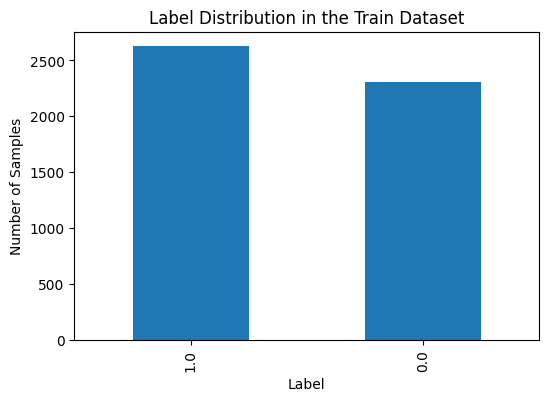

In [3]:
# dir and function to load raw data
train_data_dir = '/content/drive/My Drive/Colab Notebooks/Ecoli/train.csv'

def load_processed_data(file_path):
  return pd.read_csv(file_path)

train_data = load_processed_data(train_data_dir)
print(train_data.head())

plt.figure(figsize=(6,4))
train_data['Label'].value_counts().plot(kind='bar')
plt.title('Label Distribution in the Train Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()

##   Model

  * Model architecture: The model architecture used for this project is based on the BERT (Bidirectional Encoder Representations from Transformers) architecture, specifically tailored for clinical notes through modifications known as ClinicalBERT [2]. This adaptation includes the following elements [1]:

    * Layer Type and Size: The architecture comprises multiple layers of transformers, each consisting of multi-head attention mechanisms coupled with feed-forward neural networks.
    * Activation Function: The transformer layers use the GELU (Gaussian Error Linear Unit) activation function.
    * Embedding Layers: The model includes token embeddings, segment embeddings, and position embeddings, all of which are integral to the BERT architecture for handling sequences of tokens.
  * Training objectives:
      * Loss Function: The primary loss function used is cross-entropy loss, suitable for binary classification tasks.
      * Optimizer: The training utilizes the Adam optimizer with weight decay fix.
      * Learning Rate: A small learning rate of 1e-07 was used, with a warmup proportion to prevent the model from converging too quickly to a suboptimal solution.
  * Others: the base model is pretrained from https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz
  * I reproduced experiments for three model configurations, adapted from the paper's [repo](https://github.com/zdy93/FTL-Trans):

    * ClBERT-am (no embedding) - A Clinical BERT model adjusted mean without position embeddings.
    * ClBERT-am (all embedding) - A Clinical BERT model with full position embeddings.
    * TL-Trans (all embedding) - Time-LSTM with transformer incorporating all embeddings.

Training was performed over 3 epochs to ensure the models could be executed within a reasonable time frame as per reproducibility constraints.

I trained the model on my local machine and commented out the training andevaluation code in this notebook. I uploaded the trained TL-Trans model to the Google drive and bellow is a function to load and test it.

In [4]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 8.7 MB/s eta 0:00:00


In [5]:
!pip install pytorch_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Dongyu Zhang
"""

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import numpy as np
import six


def time_batch_generator(max_len, input_ids, labels, masks, note_ids, chunk_ids, times=None):
    """batch generator with note_id, chunk_id and time
    """
    size = len(input_ids)
    indices = np.arange(size)
    np.random.shuffle(indices)

    i = 0
    while True:
        if i < size:
            if times is not None:
                yield input_ids[indices[i]][-max_len:, :], labels[indices[i]], masks[indices[i]][-max_len:, :], \
                      note_ids[indices[i]][-max_len:], chunk_ids[indices[i]][-max_len:], times[indices[i]][-max_len:]
            else:
                yield input_ids[indices[i]][-max_len:, :], labels[indices[i]], masks[indices[i]][-max_len:, :], \
                      note_ids[indices[i]][-max_len:], chunk_ids[indices[i]][-max_len:]
            i += 1
        else:
            i = 0
            indices = np.arange(size)
            np.random.shuffle(indices)
            continue


def mask_batch_generator(max_len, input_ids, labels, masks):
    """batch generator
    """
    size = len(input_ids)
    indices = np.arange(size)
    np.random.shuffle(indices)

    i = 0
    while True:
        if i < size:
            yield input_ids[indices[i]][-max_len:, :], labels[indices[i]], masks[indices[i]][-max_len:, :]
            i += 1
        else:
            i = 0
            indices = np.arange(size)
            np.random.shuffle(indices)
            continue

def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    """Pads sequences to the same length.

    This function transforms a list of
    `num_samples` sequences (lists of integers)
    into a 2D Numpy array of shape `(num_samples, num_timesteps)`.
    `num_timesteps` is either the `maxlen` argument if provided,
    or the length of the longest sequence otherwise.

    Sequences that are shorter than `num_timesteps`
    are padded with `value` at the end.

    Sequences longer than `num_timesteps` are truncated
    so that they fit the desired length.
    The position where padding or truncation happens is determined by
    the arguments `padding` and `truncating`, respectively.

    Pre-padding is the default.

    # Arguments
        sequences: List of lists, where each element is a sequence.
        maxlen: Int, maximum length of all sequences.
        dtype: Type of the output sequences.
            To pad sequences with variable length strings, you can use `object`.
        padding: String, 'pre' or 'post':
            pad either before or after each sequence.
        truncating: String, 'pre' or 'post':
            remove values from sequences larger than
            `maxlen`, either at the beginning or at the end of the sequences.
        value: Float or String, padding value.

    # Returns
        x: Numpy array with shape `(len(sequences), maxlen)`

    # Raises
        ValueError: In case of invalid values for `truncating` or `padding`,
            or in case of invalid shape for a `sequences` entry.
    """
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    num_samples = len(sequences)

    lengths = []
    for x in sequences:
        try:
            lengths.append(len(x))
        except TypeError:
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))

    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` for variable length strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Dongyu Zhang
"""
import os
import time
import re
import io
import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, \
    auc, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score


def write_log(content, log_path, print_content=True):
    if os.path.exists(log_path):
        with open(log_path, 'a') as f:
            f.write("Time: " + time.ctime() + "\n")
            f.write(content + "\n")
            f.write("=====================\n")
    else:
        with open(log_path, 'w') as f:
            f.write("Time: " + time.ctime() + "\n")
            f.write(content + "\n")
            f.write("=====================\n")
    if print_content:
        print(content)


def preprocess1(x):
    y = re.sub('\\[(.*?)\\]', '', x)  # remove de-identified brackets
    y = re.sub('[0-9]+\.', '', y)  # remove 1.2. since the segmenter segments based on this
    y = re.sub('dr\.', 'doctor', y)
    y = re.sub('m\.d\.', 'md', y)
    y = re.sub('admission date:', '', y)
    y = re.sub('discharge date:', '', y)
    y = re.sub('--|__|==', '', y)
    return y


def preprocessing(df_less_n, tokenizer):
    df_less_n['TEXT'] = df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\n', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\r', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT'] = df_less_n['TEXT'].str.lower()

    df_less_n['TEXT'] = df_less_n['TEXT'].apply(lambda x: preprocess1(x))

    sen = df_less_n['TEXT'].values
    tokenized_texts = [tokenizer.tokenize(x) for x in sen]
    print("First sentence tokenized")
    print(tokenized_texts[0])
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    df_less_n['Input_ID'] = input_ids
    return df_less_n[['Adm_ID', 'Note_ID', 'TEXT', 'Input_ID', 'Label', 'chartdate', 'charttime']]


def word_count_pre(df_less_n):
    df_less_n['TEXT'] = df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\n', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\r', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT'] = df_less_n['TEXT'].str.lower()
    df_less_n['TEXT'] = df_less_n['TEXT'].apply(lambda x: preprocess1(x))
    return df_less_n


def split_into_chunks(df, max_len):
    input_ids = df.Input_ID.apply(lambda x: x[1:-1].replace(' ', '').split(','))
    df_len = len(df)
    Adm_ID, Note_ID, Input_ID, Label, chartdate, charttime = [], [], [], [], [], []
    for i in tqdm(range(df_len)):
        x = input_ids[i]
        n = int(len(x) / (max_len - 2))
        for j in range(n):
            Adm_ID.append(df.Adm_ID[i])
            Note_ID.append(df.Note_ID[i])
            sub_ids = x[j * (max_len - 2): (j + 1) * (max_len - 2)]
            sub_ids.insert(0, '101')
            sub_ids.append('102')
            Input_ID.append(' '.join(sub_ids))
            Label.append(df.Label[i])
            chartdate.append(df.chartdate[i])
            charttime.append(df.charttime[i])
        if len(x) % (max_len - 2) > 10:
            Adm_ID.append(df.Adm_ID[i])
            Note_ID.append(df.Note_ID[i])
            sub_ids = x[-((len(x)) % (max_len - 2)):]
            sub_ids.insert(0, '101')
            sub_ids.append('102')
            Input_ID.append(' '.join(sub_ids))
            Label.append(df.Label[i])
            chartdate.append(df.chartdate[i])
            charttime.append(df.charttime[i])
    new_df = pd.DataFrame({'Adm_ID': Adm_ID,
                           'Note_ID': Note_ID,
                           'Input_ID': Input_ID,
                           'Label': Label,
                           'chartdate': chartdate,
                           'charttime': charttime})
    new_df = new_df.astype({'Adm_ID': 'int64', 'Note_ID': 'int64', 'Label': 'int64'})
    return new_df


def Tokenize(df, max_length, tokenizer):
    labels = df.Label.values
    if 'TEXT' in df.columns:
        sen = df.TEXT.values
        labels = df.Label.values
        sen = ["[CLS] " + x + " [SEP]" for x in sen]
        tokenized_texts = [tokenizer.tokenize(x) for x in sen]
        print("First sentence tokenized")
        print(tokenized_texts[0])
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    else:
        assert 'Input_ID' in df.columns
        input_ids = df.Input_ID.apply(lambda x: x[1:-1].split(', '))
        input_ids = input_ids.apply(lambda x: [int(i) for i in x])
        input_ids = input_ids.values
    input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    return labels, input_ids, attention_masks


def Tokenize_with_note_id(df, max_length, tokenizer):
    labels = df.Label.values
    note_ids = df.Note_ID.values
    if 'TEXT' in df.columns:
        sen = df.TEXT.values
        labels = df.Label.values
        sen = ["[CLS] " + x + " [SEP]" for x in sen]
        tokenized_texts = [tokenizer.tokenize(x) for x in sen]
        print("First sentence tokenized")
        print(tokenized_texts[0])
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    else:
        assert 'Input_ID' in df.columns
        input_ids = df.Input_ID.apply(lambda x: x[1:-1].split(', '))
        input_ids = input_ids.apply(lambda x: [int(i) for i in x])
        input_ids = input_ids.values
    input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    return labels, input_ids, attention_masks, note_ids


def Tokenize_with_note_id_time(df, max_length, tokenizer):
    labels = df.Label.values
    note_ids = df.Note_ID.values
    times = pd.to_datetime(df.chartdate.values)
    times = times - times.min()
    times = times.days.values
    if 'TEXT' in df.columns:
        sen = df.TEXT.values
        labels = df.Label.values
        sen = ["[CLS] " + x + " [SEP]" for x in sen]
        tokenized_texts = [tokenizer.tokenize(x) for x in sen]
        print("First sentence tokenized")
        print(tokenized_texts[0])
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    else:
        assert 'Input_ID' in df.columns
        input_ids = df.Input_ID.apply(lambda x: x.split(' '))
        input_ids = input_ids.apply(lambda x: [int(i) for i in x])
        input_ids = input_ids.values
    input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    return labels, input_ids, attention_masks, note_ids, times


def Tokenize_with_note_id_hour(df, max_length, tokenizer):
    labels = df.Label.values
    note_ids = df.Note_ID.values
    times = pd.to_datetime(df.charttime.values)
    times = times - times.min()
    times = times / pd.Timedelta(days=1)
    if 'TEXT' in df.columns:
        sen = df.TEXT.values
        labels = df.Label.values
        sen = ["[CLS] " + x + " [SEP]" for x in sen]
        tokenized_texts = [tokenizer.tokenize(x) for x in sen]
        print("First sentence tokenized")
        print(tokenized_texts[0])
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    else:
        assert 'Input_ID' in df.columns
        input_ids = df.Input_ID.apply(lambda x: x[1:-1].split(', '))
        input_ids = input_ids.apply(lambda x: [int(i) for i in x])
        input_ids = input_ids.values
    input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    return labels, input_ids, attention_masks, note_ids, times


def reorder_by_time(data):
    data.chartdate = pd.to_datetime(data.chartdate)
    data.charttime = pd.to_datetime(data.charttime)
    data.loc[data.charttime.isna(), 'charttime'] = data[data.charttime.isna()].chartdate + pd.Timedelta(hours=23,
                                                                                                        minutes=59,
                                                                                                        seconds=59)
    data = data.sort_values(by=['Adm_ID', 'charttime', 'Note_ID'])
    data.reset_index(inplace=True)
    return data


def concat_by_id_list(df, labels, inputs, masks, str_len):
    final_labels, final_inputs, final_masks = [], [], []
    id_lists = df.Adm_ID.unique()
    for id in id_lists:
        id_ix = df.index[df.Adm_ID == id].to_list()
        final_inputs.append(inputs[id_ix])
        final_masks.append(masks[id_ix])
        final_labels.append(labels[id_ix].max())
    return final_labels, final_inputs, final_masks, id_lists


def concat_by_id_list_with_note_chunk_id(df, labels, inputs, masks, note_ids, str_len):
    final_labels, final_inputs, final_masks, final_note_ids, final_chunk_ids = [], [], [], [], []
    id_lists = df.Adm_ID.unique()
    for id in id_lists:
        id_ix = df.index[df.Adm_ID == id].to_list()
        final_inputs.append(inputs[id_ix])
        final_masks.append(masks[id_ix])
        final_labels.append(labels[id_ix].max())
        final_note_ids.append(note_ids[id_ix])
        final_chunk_ids.append(torch.tensor(list(range(len(id_ix)))[::-1]))
    return final_labels, final_inputs, final_masks, id_lists, final_note_ids, final_chunk_ids


def concat_by_id_list_with_note_chunk_id_time(df, labels, inputs, masks, note_ids, times, str_len):
    final_labels, final_inputs, final_masks, final_note_ids, final_chunk_ids, final_times = [], [], [], [], [], []
    id_lists = df.Adm_ID.unique()
    for id in id_lists:
        id_ix = df.index[df.Adm_ID == id].to_list()
        final_inputs.append(inputs[id_ix])
        final_masks.append(masks[id_ix])
        final_labels.append(labels[id_ix].max())
        final_note_ids.append(note_ids[id_ix])
        final_chunk_ids.append(torch.tensor(list(range(len(id_ix)))[::-1]))
        final_times.append(torch.tensor(np.concatenate([np.zeros(1), np.diff(times[id_ix])])))
    return final_labels, final_inputs, final_masks, id_lists, final_note_ids, final_chunk_ids, final_times


def convert_note_ids(note_ids):
    new_dict = dict(zip(pd.Series(note_ids).unique(), range(len(pd.Series(note_ids).unique()))[::-1]))
    new_ids = [new_dict[i] for i in note_ids]
    return torch.tensor(new_ids)


def flat_accuracy(preds, labels):
    pred_flat = np.asarray([1 if i else 0 for i in (preds.flatten() >= 0.5)])
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def model_auc(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr, thresholds


def model_aupr(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    aupr_score = auc(recall, precision)
    return aupr_score, precision, recall, thresholds


def write_performance(flat_true_labels, flat_predictions, flat_logits, config):
    test_accuracy = accuracy_score(flat_true_labels, flat_predictions)

    test_f1 = f1_score(flat_true_labels, flat_predictions, average='binary')

    test_prec = precision_score(flat_true_labels, flat_predictions, average='binary')

    test_rec = recall_score(flat_true_labels, flat_predictions, average='binary')

    test_auc, _, _, _ = model_auc(flat_true_labels, flat_logits)

    test_mc = matthews_corrcoef(flat_true_labels, flat_predictions)

    test_aupr, _, _, _ = model_aupr(flat_true_labels, flat_logits)

    test_msl = 64

    test_seed = 42

    test_dir_code = "./Ecoli"

    test_time = time.ctime()

    exp_path = "{}_{}_{}.csv".format(config.task_name, config.embed_mode, test_msl)

    header = "Len,Dir,Seed,Accuracy,F1_Score,Precision,Recall,AUC,MCC,AUPR,Time"
    content = "{},{},{},{},{},{},{},{},{},{},{}".format(test_msl,
                                                        test_dir_code,
                                                        test_seed,
                                                        test_accuracy,
                                                        test_f1,
                                                        test_prec,
                                                        test_rec,
                                                        test_auc,
                                                        test_mc,
                                                        test_aupr,
                                                        test_time)

    print("Test Patient Level Accuracy: {}\n"
              "Test Patient Level F1 Score: {}\n"
              "Test Patient Level Precision: {}\n"
              "Test Patient Level Recall: {}\n"
              "Test Patient Level AUC: {} \n"
              "Test Patient Level Matthew's correlation coefficient: {}\n"
              "Test Patient Level AUPR: {} \n"
              "All Finished!".format(test_accuracy,
                                     test_f1,
                                     test_prec,
                                     test_rec,
                                     test_auc,
                                     test_mc,
                                     test_aupr))



"""
Utilities for working with the local dataset cache.
This file is adapted from the AllenNLP library at https://github.com/allenai/allennlp
Copyright by the AllenNLP authors.
"""
from __future__ import (absolute_import, division, print_function, unicode_literals)

import json
import logging
import os
import shutil
import tempfile
from functools import wraps
from hashlib import sha256
import sys
from io import open

import boto3
import requests
from botocore.exceptions import ClientError
from tqdm import tqdm

try:
    from urllib.parse import urlparse
except ImportError:
    from urlparse import urlparse

try:
    from pathlib import Path
    PYTORCH_PRETRAINED_BERT_CACHE = Path(os.getenv('PYTORCH_PRETRAINED_BERT_CACHE',
                                                   Path.home() / '.pytorch_pretrained_bert'))
except (AttributeError, ImportError):
    PYTORCH_PRETRAINED_BERT_CACHE = os.getenv('PYTORCH_PRETRAINED_BERT_CACHE',
                                              os.path.join(os.path.expanduser("~"), '.pytorch_pretrained_bert'))

logger = logging.getLogger(__name__)  # pylint: disable=invalid-name


def url_to_filename(url, etag=None):
    """
    Convert `url` into a hashed filename in a repeatable way.
    If `etag` is specified, append its hash to the url's, delimited
    by a period.
    """
    url_bytes = url.encode('utf-8')
    url_hash = sha256(url_bytes)
    filename = url_hash.hexdigest()

    if etag:
        etag_bytes = etag.encode('utf-8')
        etag_hash = sha256(etag_bytes)
        filename += '.' + etag_hash.hexdigest()

    return filename


def filename_to_url(filename, cache_dir=None):
    """
    Return the url and etag (which may be ``None``) stored for `filename`.
    Raise ``EnvironmentError`` if `filename` or its stored metadata do not exist.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BERT_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    cache_path = os.path.join(cache_dir, filename)
    if not os.path.exists(cache_path):
        raise EnvironmentError("file {} not found".format(cache_path))

    meta_path = cache_path + '.json'
    if not os.path.exists(meta_path):
        raise EnvironmentError("file {} not found".format(meta_path))

    with open(meta_path, encoding="utf-8") as meta_file:
        metadata = json.load(meta_file)
    url = metadata['url']
    etag = metadata['etag']

    return url, etag


def cached_path(url_or_filename, cache_dir=None):
    """
    Given something that might be a URL (or might be a local path),
    determine which. If it's a URL, download the file and cache it, and
    return the path to the cached file. If it's already a local path,
    make sure the file exists and then return the path.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BERT_CACHE
    if sys.version_info[0] == 3 and isinstance(url_or_filename, Path):
        url_or_filename = str(url_or_filename)
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    parsed = urlparse(url_or_filename)

    if parsed.scheme in ('http', 'https', 's3'):
        # URL, so get it from the cache (downloading if necessary)
        return get_from_cache(url_or_filename, cache_dir)
    elif os.path.exists(url_or_filename):
        # File, and it exists.
        return url_or_filename
    elif parsed.scheme == '':
        # File, but it doesn't exist.
        raise EnvironmentError("file {} not found".format(url_or_filename))
    else:
        # Something unknown
        raise ValueError("unable to parse {} as a URL or as a local path".format(url_or_filename))


def split_s3_path(url):
    """Split a full s3 path into the bucket name and path."""
    parsed = urlparse(url)
    if not parsed.netloc or not parsed.path:
        raise ValueError("bad s3 path {}".format(url))
    bucket_name = parsed.netloc
    s3_path = parsed.path
    # Remove '/' at beginning of path.
    if s3_path.startswith("/"):
        s3_path = s3_path[1:]
    return bucket_name, s3_path


def s3_request(func):
    """
    Wrapper function for s3 requests in order to create more helpful error
    messages.
    """

    @wraps(func)
    def wrapper(url, *args, **kwargs):
        try:
            return func(url, *args, **kwargs)
        except ClientError as exc:
            if int(exc.response["Error"]["Code"]) == 404:
                raise EnvironmentError("file {} not found".format(url))
            else:
                raise

    return wrapper


@s3_request
def s3_etag(url):
    """Check ETag on S3 object."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_object = s3_resource.Object(bucket_name, s3_path)
    return s3_object.e_tag


@s3_request
def s3_get(url, temp_file):
    """Pull a file directly from S3."""
    s3_resource = boto3.resource("s3")
    bucket_name, s3_path = split_s3_path(url)
    s3_resource.Bucket(bucket_name).download_fileobj(s3_path, temp_file)


def http_get(url, temp_file):
    req = requests.get(url, stream=True)
    content_length = req.headers.get('Content-Length')
    total = int(content_length) if content_length is not None else None
    progress = tqdm(unit="B", total=total)
    for chunk in req.iter_content(chunk_size=1024):
        if chunk: # filter out keep-alive new chunks
            progress.update(len(chunk))
            temp_file.write(chunk)
    progress.close()


def get_from_cache(url, cache_dir=None):
    """
    Given a URL, look for the corresponding dataset in the local cache.
    If it's not there, download it. Then return the path to the cached file.
    """
    if cache_dir is None:
        cache_dir = PYTORCH_PRETRAINED_BERT_CACHE
    if sys.version_info[0] == 3 and isinstance(cache_dir, Path):
        cache_dir = str(cache_dir)

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Get eTag to add to filename, if it exists.
    if url.startswith("s3://"):
        etag = s3_etag(url)
    else:
        response = requests.head(url, allow_redirects=True)
        if response.status_code != 200:
            raise IOError("HEAD request failed for url {} with status code {}"
                          .format(url, response.status_code))
        etag = response.headers.get("ETag")

    filename = url_to_filename(url, etag)

    # get cache path to put the file
    cache_path = os.path.join(cache_dir, filename)

    if not os.path.exists(cache_path):
        # Download to temporary file, then copy to cache dir once finished.
        # Otherwise you get corrupt cache entries if the download gets interrupted.
        with tempfile.NamedTemporaryFile() as temp_file:
            logger.info("%s not found in cache, downloading to %s", url, temp_file.name)

            # GET file object
            if url.startswith("s3://"):
                s3_get(url, temp_file)
            else:
                http_get(url, temp_file)

            # we are copying the file before closing it, so flush to avoid truncation
            temp_file.flush()
            # shutil.copyfileobj() starts at the current position, so go to the start
            temp_file.seek(0)

            logger.info("copying %s to cache at %s", temp_file.name, cache_path)
            with open(cache_path, 'wb') as cache_file:
                shutil.copyfileobj(temp_file, cache_file)

            logger.info("creating metadata file for %s", cache_path)
            meta = {'url': url, 'etag': etag}
            meta_path = cache_path + '.json'
            with open(meta_path, 'w', encoding="utf-8") as meta_file:
                json.dump(meta, meta_file)

            logger.info("removing temp file %s", temp_file.name)

    return cache_path


def read_set_from_file(filename):
    '''
    Extract a de-duped collection (set) of text from a file.
    Expected file format is one item per line.
    '''
    collection = set()
    with open(filename, 'r', encoding='utf-8') as file_:
        for line in file_:
            collection.add(line.rstrip())
    return collection


def get_file_extension(path, dot=True, lower=True):
    ext = os.path.splitext(path)[1]
    ext = ext if dot else ext[1:]
    return ext.lower() if lower else ext

In [7]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch BERT model. """

from __future__ import absolute_import, division, print_function, unicode_literals

import json
import logging
import math
import os
import sys
from io import open

import torch
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss


logger = logging.getLogger(__name__)

BERT_PRETRAINED_MODEL_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-pytorch_model.bin",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin",
    'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-pytorch_model.bin",
    'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-pytorch_model.bin",
    'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-pytorch_model.bin",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-pytorch_model.bin",
    'bert-base-german-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-pytorch_model.bin",
    'bert-large-uncased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-pytorch_model.bin",
    'bert-large-cased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-pytorch_model.bin",
    'bert-large-uncased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-pytorch_model.bin",
    'bert-large-cased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-pytorch_model.bin",
    'bert-base-cased-finetuned-mrpc': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-pytorch_model.bin",
}

BERT_PRETRAINED_CONFIG_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json",
    'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-config.json",
    'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json",
    'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json",
    'bert-base-german-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-german-cased-config.json",
    'bert-large-uncased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json",
    'bert-large-cased-whole-word-masking': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-config.json",
    'bert-large-uncased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-finetuned-squad-config.json",
    'bert-large-cased-whole-word-masking-finetuned-squad': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-whole-word-masking-finetuned-squad-config.json",
    'bert-base-cased-finetuned-mrpc': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-finetuned-mrpc-config.json",
}


def load_tf_weights_in_bert(model, config, tf_checkpoint_path):
    """ Load tf checkpoints in a pytorch model.
    """
    try:
        import re
        import numpy as np
        import tensorflow as tf
    except ImportError:
        logger.error("Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions.")
        raise
    tf_path = os.path.abspath(tf_checkpoint_path)
    logger.info("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []
    for name, shape in init_vars:
        logger.info("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array)

    for name, array in zip(names, arrays):
        name = name.split('/')
        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(n in ["adam_v", "adam_m", "global_step"] for n in name):
            logger.info("Skipping {}".format("/".join(name)))
            continue
        pointer = model
        for m_name in name:
            if re.fullmatch(r'[A-Za-z]+_\d+', m_name):
                l = re.split(r'_(\d+)', m_name)
            else:
                l = [m_name]
            if l[0] == 'kernel' or l[0] == 'gamma':
                pointer = getattr(pointer, 'weight')
            elif l[0] == 'output_bias' or l[0] == 'beta':
                pointer = getattr(pointer, 'bias')
            elif l[0] == 'output_weights':
                pointer = getattr(pointer, 'weight')
            elif l[0] == 'squad':
                pointer = getattr(pointer, 'classifier')
            else:
                try:
                    pointer = getattr(pointer, l[0])
                except AttributeError:
                    logger.info("Skipping {}".format("/".join(name)))
                    continue
            if len(l) >= 2:
                num = int(l[1])
                pointer = pointer[num]
        if m_name[-11:] == '_embeddings':
            pointer = getattr(pointer, 'weight')
        elif m_name == 'kernel':
            array = np.transpose(array)
        try:
            assert pointer.shape == array.shape
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        logger.info("Initialize PyTorch weight {}".format(name))
        pointer.data = torch.from_numpy(array)
    return model


def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": swish}


class PretrainedConfig(object):
    r""" Base class for all configuration classes.
        Handles a few parameters common to all models' configurations as well as methods for loading/downloading/saving configurations.

        Note:
            A configuration file can be loaded and saved to disk. Loading the configuration file and using this file to initialize a model does **not** load the model weights.
            It only affects the model's configuration.

        Class attributes (overridden by derived classes):
            - ``pretrained_config_archive_map``: a python ``dict`` of with `short-cut-names` (string) as keys and `url` (string) of associated pretrained model configurations as values.

        Parameters:
            ``finetuning_task``: string, default `None`. Name of the task used to fine-tune the model. This can be used when converting from an original (TensorFlow or PyTorch) checkpoint.
            ``num_labels``: integer, default `2`. Number of classes to use when the model is a classification model (sequences/tokens)
            ``output_attentions``: boolean, default `False`. Should the model returns attentions weights.
            ``output_hidden_states``: string, default `False`. Should the model returns all hidden-states.
            ``torchscript``: string, default `False`. Is the model used with Torchscript.
    """
    pretrained_config_archive_map = {}

    def __init__(self, **kwargs):
        self.finetuning_task = kwargs.pop('finetuning_task', None)
        self.num_labels = kwargs.pop('num_labels', 2)
        self.output_attentions = kwargs.pop('output_attentions', False)
        self.output_hidden_states = kwargs.pop('output_hidden_states', False)
        self.torchscript = kwargs.pop('torchscript', False)
        self.pruned_heads = kwargs.pop('pruned_heads', {})

    def save_pretrained(self, save_directory):
        """ Save a configuration object to the directory `save_directory`, so that it
            can be re-loaded using the :func:`~pytorch_transformers.PretrainedConfig.from_pretrained` class method.
        """
        assert os.path.isdir(save_directory), "Saving path should be a directory where the model and configuration can be saved"

        # If we save using the predefined names, we can load using `from_pretrained`
        output_config_file = os.path.join(save_directory, CONFIG_NAME)

        self.to_json_file(output_config_file)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, **kwargs):
        r""" Instantiate a :class:`~pytorch_transformers.PretrainedConfig` (or a derived class) from a pre-trained model configuration.

        Parameters:
            pretrained_model_name_or_path: either:

                - a string with the `shortcut name` of a pre-trained model configuration to load from cache or download, e.g.: ``bert-base-uncased``.
                - a path to a `directory` containing a configuration file saved using the :func:`~pytorch_transformers.PretrainedConfig.save_pretrained` method, e.g.: ``./my_model_directory/``.
                - a path or url to a saved configuration JSON `file`, e.g.: ``./my_model_directory/configuration.json``.

            cache_dir: (`optional`) string:
                Path to a directory in which a downloaded pre-trained model
                configuration should be cached if the standard cache should not be used.

            kwargs: (`optional`) dict: key/value pairs with which to update the configuration object after loading.

                - The values in kwargs of any keys which are configuration attributes will be used to override the loaded values.
                - Behavior concerning key/value pairs whose keys are *not* configuration attributes is controlled by the `return_unused_kwargs` keyword parameter.

            force_download: (`optional`) boolean, default False:
                Force to (re-)download the model weights and configuration files and override the cached versions if they exists.

            proxies: (`optional`) dict, default None:
                A dictionary of proxy servers to use by protocol or endpoint, e.g.: {'http': 'foo.bar:3128', 'http://hostname': 'foo.bar:4012'}.
                The proxies are used on each request.

            return_unused_kwargs: (`optional`) bool:

                - If False, then this function returns just the final configuration object.
                - If True, then this functions returns a tuple `(config, unused_kwargs)` where `unused_kwargs` is a dictionary consisting of the key/value pairs whose keys are not configuration attributes: ie the part of kwargs which has not been used to update `config` and is otherwise ignored.

        Examples::

            # We can't instantiate directly the base class `PretrainedConfig` so let's show the examples on a
            # derived class: BertConfig
            config = BertConfig.from_pretrained('bert-base-uncased')    # Download configuration from S3 and cache.
            config = BertConfig.from_pretrained('./test/saved_model/')  # E.g. config (or model) was saved using `save_pretrained('./test/saved_model/')`
            config = BertConfig.from_pretrained('./test/saved_model/my_configuration.json')
            config = BertConfig.from_pretrained('bert-base-uncased', output_attention=True, foo=False)
            assert config.output_attention == True
            config, unused_kwargs = BertConfig.from_pretrained('bert-base-uncased', output_attention=True,
                                                               foo=False, return_unused_kwargs=True)
            assert config.output_attention == True
            assert unused_kwargs == {'foo': False}

        """
        cache_dir = kwargs.pop('cache_dir', None)
        force_download = kwargs.pop('force_download', False)
        proxies = kwargs.pop('proxies', None)
        return_unused_kwargs = kwargs.pop('return_unused_kwargs', False)

        if pretrained_model_name_or_path in cls.pretrained_config_archive_map:
            config_file = cls.pretrained_config_archive_map[pretrained_model_name_or_path]
        elif os.path.isdir(pretrained_model_name_or_path):
            config_file = os.path.join(pretrained_model_name_or_path, CONFIG_NAME)
        else:
            config_file = pretrained_model_name_or_path
        # redirect to the cache, if necessary
        try:
            resolved_config_file = cached_path(config_file, cache_dir=cache_dir, force_download=force_download, proxies=proxies)
        except EnvironmentError as e:
            if pretrained_model_name_or_path in cls.pretrained_config_archive_map:
                logger.error(
                    "Couldn't reach server at '{}' to download pretrained model configuration file.".format(
                        config_file))
            else:
                logger.error(
                    "Model name '{}' was not found in model name list ({}). "
                    "We assumed '{}' was a path or url but couldn't find any file "
                    "associated to this path or url.".format(
                        pretrained_model_name_or_path,
                        ', '.join(cls.pretrained_config_archive_map.keys()),
                        config_file))
            raise e
        if resolved_config_file == config_file:
            logger.info("loading configuration file {}".format(config_file))
        else:
            logger.info("loading configuration file {} from cache at {}".format(
                config_file, resolved_config_file))

        # Load config
        config = cls.from_json_file(resolved_config_file)

        if hasattr(config, 'pruned_heads'):
            config.pruned_heads = dict((int(key), set(value)) for key, value in config.pruned_heads.items())

        # Update config with kwargs if needed
        to_remove = []
        for key, value in kwargs.items():
            if hasattr(config, key):
                setattr(config, key, value)
                to_remove.append(key)
        for key in to_remove:
            kwargs.pop(key, None)

        logger.info("Model config %s", config)
        if return_unused_kwargs:
            return config, kwargs
        else:
            return config

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `Config` from a Python dictionary of parameters."""
        config = cls(vocab_size_or_config_json_file=-1)
        for key, value in json_object.items():
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BertConfig` from a json file of parameters."""
        with open(json_file, "r", encoding='utf-8') as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

    def to_json_file(self, json_file_path):
        """ Save this instance to a json file."""
        with open(json_file_path, "w", encoding='utf-8') as writer:
            writer.write(self.to_json_string())


class BertConfig(PretrainedConfig):
    r"""
        :class:`~pytorch_transformers.BertConfig` is the configuration class to store the configuration of a
        `BertModel`.


        Arguments:
            vocab_size_or_config_json_file: Vocabulary size of `inputs_ids` in `BertModel`.
            hidden_size: Size of the encoder layers and the pooler layer.
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler. If string, "gelu", "relu" and "swish" are supported.
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `BertModel`.
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
            layer_norm_eps: The epsilon used by LayerNorm.
    """
    pretrained_config_archive_map = BERT_PRETRAINED_CONFIG_ARCHIVE_MAP

    def __init__(self,
                 vocab_size_or_config_json_file=30522,
                 hidden_size=768,
                 num_hidden_layers=12,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 hidden_act="gelu",
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 type_vocab_size=2,
                 initializer_range=0.02,
                 layer_norm_eps=1e-12,
                 **kwargs):
        super(BertConfig, self).__init__(**kwargs)
        if isinstance(vocab_size_or_config_json_file, str) or (sys.version_info[0] == 2
                        and isinstance(vocab_size_or_config_json_file, unicode)):
            with open(vocab_size_or_config_json_file, "r", encoding='utf-8') as reader:
                json_config = json.loads(reader.read())
            for key, value in json_config.items():
                self.__dict__[key] = value
        elif isinstance(vocab_size_or_config_json_file, int):
            self.vocab_size = vocab_size_or_config_json_file
            self.hidden_size = hidden_size
            self.num_hidden_layers = num_hidden_layers
            self.num_attention_heads = num_attention_heads
            self.hidden_act = hidden_act
            self.intermediate_size = intermediate_size
            self.hidden_dropout_prob = hidden_dropout_prob
            self.attention_probs_dropout_prob = attention_probs_dropout_prob
            self.max_position_embeddings = max_position_embeddings
            self.type_vocab_size = type_vocab_size
            self.initializer_range = initializer_range
            self.layer_norm_eps = layer_norm_eps
        else:
            raise ValueError("First argument must be either a vocabulary size (int)"
                             " or the path to a pretrained model config file (str)")



try:
    from apex.normalization.fused_layer_norm import FusedLayerNorm as BertLayerNorm
except (ImportError, AttributeError) as e:
    logger.info("Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .")
    BertLayerNorm = torch.nn.LayerNorm

class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None, position_ids=None):
        seq_length = input_ids.size(1)
        if position_ids is None:
            position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.output_attentions = config.output_attentions

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask, head_mask=None):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        outputs = (context_layer, attention_probs) if self.output_attentions else (context_layer,)
        return outputs


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        mask = torch.ones(self.self.num_attention_heads, self.self.attention_head_size)
        heads = set(heads) - self.pruned_heads  # Convert to set and emove already pruned heads
        for head in heads:
            # Compute how many pruned heads are before the head and move the index accordingly
            head = head - sum(1 if h < head else 0 for h in self.pruned_heads)
            mask[head] = 0
        mask = mask.view(-1).contiguous().eq(1)
        index = torch.arange(len(mask))[mask].long()

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(self, input_tensor, attention_mask, head_mask=None):
        self_outputs = self.self(input_tensor, attention_mask, head_mask)
        attention_output = self.output(self_outputs[0], input_tensor)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask, head_mask=None):
        attention_outputs = self.attention(hidden_states, attention_mask, head_mask)
        attention_output = attention_outputs[0]
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        outputs = (layer_output,) + attention_outputs[1:]  # add attentions if we output them
        return outputs


class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        self.output_attentions = config.output_attentions
        self.output_hidden_states = config.output_hidden_states
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, head_mask=None):
        all_hidden_states = ()
        all_attentions = ()
        for i, layer_module in enumerate(self.layer):
            if self.output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(hidden_states, attention_mask, head_mask[i])
            hidden_states = layer_outputs[0]

            if self.output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        # Add last layer
        if self.output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if self.output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if self.output_attentions:
            outputs = outputs + (all_attentions,)
        return outputs  # last-layer hidden state, (all hidden states), (all attentions)


class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super(BertPredictionHeadTransform, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


class BertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super(BertLMPredictionHead, self).__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(config.hidden_size,
                                 config.vocab_size,
                                 bias=False)

        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states) + self.bias
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config):
        super(BertOnlyMLMHead, self).__init__()
        self.predictions = BertLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


class BertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super(BertOnlyNSPHead, self).__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score


class BertPreTrainingHeads(nn.Module):
    def __init__(self, config):
        super(BertPreTrainingHeads, self).__init__()
        self.predictions = BertLMPredictionHead(config)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score


class PreTrainedBertModel(nn.Module):
    """ An abstract class to handle weights initialization and
        a simple interface for dowloading and loading pretrained models.
    """
    def __init__(self, config, *inputs, **kwargs):
        super(PreTrainedBertModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.beta.data.normal_(mean=0.0, std=self.config.initializer_range)
            module.gamma.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(cls, pretrained_model_name, *inputs, **kwargs):
        """
        Instantiate a PreTrainedBertModel from a pre-trained model file.
        Download and cache the pre-trained model file if needed.

        Params:
            pretrained_model_name: either:
                - a str with the name of a pre-trained model to load selected in the list of:
                    . `bert-base-uncased`
                    . `bert-large-uncased`
                    . `bert-base-cased`
                    . `bert-base-multilingual`
                    . `bert-base-chinese`
                - a path or url to a pretrained model archive containing:
                    . `bert_config.json` a configuration file for the model
                    . `pytorch_model.bin` a PyTorch dump of a BertForPreTraining instance
            *inputs, **kwargs: additional input for the specific Bert class
                (ex: num_labels for BertForSequenceClassification)
        """
        if pretrained_model_name in PRETRAINED_MODEL_ARCHIVE_MAP:
            archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name]
        else:
            archive_file = pretrained_model_name
        # redirect to the cache, if necessary
        try:
            resolved_archive_file = cached_path(archive_file)
        except FileNotFoundError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name,
                    ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),
                    pretrained_model_name))
            return None
        if resolved_archive_file == archive_file:
            logger.info("loading archive file {}".format(archive_file))
        else:
            logger.info("loading archive file {} from cache at {}".format(
                archive_file, resolved_archive_file))
        tempdir = None
        if os.path.isdir(resolved_archive_file):
            serialization_dir = resolved_archive_file
        else:
            # Extract archive to temp dir
            tempdir = tempfile.mkdtemp()
            logger.info("extracting archive file {} to temp dir {}".format(
                resolved_archive_file, tempdir))
            with tarfile.open(resolved_archive_file, 'r:gz') as archive:
                archive.extractall(tempdir)
            serialization_dir = tempdir
        # Load config
        config_file = os.path.join(serialization_dir, CONFIG_NAME)
        config = BertConfig.from_json_file(config_file)
        logger.info("Model config {}".format(config))
        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
        state_dict = torch.load(weights_path, map_location = 'cpu')

        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        load(model, prefix='' if hasattr(model, 'bert') else 'bert.')
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(
                model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(
                model.__class__.__name__, unexpected_keys))
        if tempdir:
            # Clean up temp dir
            shutil.rmtree(tempdir)
        return model


class PreTrainedBertModel(nn.Module):
    """ An abstract class to handle weights initialization and
        a simple interface for dowloading and loading pretrained models.
    """
    def __init__(self, config, *inputs, **kwargs):
        super(PreTrainedBertModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.beta.data.normal_(mean=0.0, std=self.config.initializer_range)
            module.gamma.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(cls, pretrained_model_name, *inputs, **kwargs):
        """
        Instantiate a PreTrainedBertModel from a pre-trained model file.
        Download and cache the pre-trained model file if needed.

        Params:
            pretrained_model_name: either:
                - a str with the name of a pre-trained model to load selected in the list of:
                    . `bert-base-uncased`
                    . `bert-large-uncased`
                    . `bert-base-cased`
                    . `bert-base-multilingual`
                    . `bert-base-chinese`
                - a path or url to a pretrained model archive containing:
                    . `bert_config.json` a configuration file for the model
                    . `pytorch_model.bin` a PyTorch dump of a BertForPreTraining instance
            *inputs, **kwargs: additional input for the specific Bert class
                (ex: num_labels for BertForSequenceClassification)
        """
        if pretrained_model_name in PRETRAINED_MODEL_ARCHIVE_MAP:
            archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name]
        else:
            archive_file = pretrained_model_name
        # redirect to the cache, if necessary
        try:
            resolved_archive_file = cached_path(archive_file)
        except FileNotFoundError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name,
                    ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),
                    pretrained_model_name))
            return None
        if resolved_archive_file == archive_file:
            logger.info("loading archive file {}".format(archive_file))
        else:
            logger.info("loading archive file {} from cache at {}".format(
                archive_file, resolved_archive_file))
        tempdir = None
        if os.path.isdir(resolved_archive_file):
            serialization_dir = resolved_archive_file
        else:
            # Extract archive to temp dir
            tempdir = tempfile.mkdtemp()
            logger.info("extracting archive file {} to temp dir {}".format(
                resolved_archive_file, tempdir))
            with tarfile.open(resolved_archive_file, 'r:gz') as archive:
                archive.extractall(tempdir)
            serialization_dir = tempdir
        # Load config
        config_file = os.path.join(serialization_dir, CONFIG_NAME)
        config = BertConfig.from_json_file(config_file)
        logger.info("Model config {}".format(config))
        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
        state_dict = torch.load(weights_path, map_location = 'cpu')

        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        load(model, prefix='' if hasattr(model, 'bert') else 'bert.')
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(
                model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(
                model.__class__.__name__, unexpected_keys))
        if tempdir:
            # Clean up temp dir
            shutil.rmtree(tempdir)
        return model


class BertModel(PreTrainedBertModel):
    """BERT model ("Bidirectional Embedding Representations from a Transformer").

    Params:
        config: a BertConfig class instance with the configuration to build a new model

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `output_all_encoded_layers`: boolean which controls the content of the `encoded_layers` output as described below. Default: `True`.

    Outputs: Tuple of (encoded_layers, pooled_output)
        `encoded_layers`: controled by `output_all_encoded_layers` argument:
            - `output_all_encoded_layers=True`: outputs a list of the full sequences of encoded-hidden-states at the end
                of each attention block (i.e. 12 full sequences for BERT-base, 24 for BERT-large), each
                encoded-hidden-state is a torch.FloatTensor of size [batch_size, sequence_length, hidden_size],
            - `output_all_encoded_layers=False`: outputs only the full sequence of hidden-states corresponding
                to the last attention block,
        `pooled_output`: a torch.FloatTensor of size [batch_size, hidden_size] which is the output of a
            classifier pretrained on top of the hidden state associated to the first character of the
            input (`CLF`) to train on the Next-Sentence task (see BERT's paper).

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = modeling.BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    model = modeling.BertModel(config=config)
    all_encoder_layers, pooled_output = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, token_type_ids)
        encoded_layers = self.encoder(embedding_output,
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]
        pooled_output = self.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output


class BertForPreTraining(PreTrainedBertModel):
    r"""
        **masked_lm_labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size, sequence_length)``:
            Labels for computing the masked language modeling loss.
            Indices should be in ``[-1, 0, ..., config.vocab_size]`` (see ``input_ids`` docstring)
            Tokens with indices set to ``-1`` are ignored (masked), the loss is only computed for the tokens with labels
            in ``[0, ..., config.vocab_size]``
        **next_sentence_label**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the next sequence prediction (classification) loss. Input should be a sequence pair (see ``input_ids`` docstring)
            Indices should be in ``[0, 1]``.
            ``0`` indicates sequence B is a continuation of sequence A,
            ``1`` indicates sequence B is a random sequence.

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when both ``masked_lm_labels`` and ``next_sentence_label`` are provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Total loss as the sum of the masked language modeling loss and the next sequence prediction (classification) loss.
        **prediction_scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length, config.vocab_size)``
            Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
        **seq_relationship_scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length, 2)``
            Prediction scores of the next sequence prediction (classification) head (scores of True/False continuation before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForPreTraining.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids)
        prediction_scores, seq_relationship_scores = outputs[:2]

    """
    def __init__(self, config):
        super(BertForPreTraining, self).__init__(config)

        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config)

        self.init_weights()
        self.tie_weights()

    def tie_weights(self):
        """ Make sure we are sharing the input and output embeddings.
            Export to TorchScript can't handle parameter sharing so we are cloning them instead.
        """
        self._tie_or_clone_weights(self.cls.predictions.decoder,
                                   self.bert.embeddings.word_embeddings)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None,
                next_sentence_label=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)

        sequence_output, pooled_output = outputs[:2]
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)

        outputs = (prediction_scores, seq_relationship_score,) + outputs[2:]  # add hidden states and attention if they are here

        if masked_lm_labels is not None and next_sentence_label is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
            total_loss = masked_lm_loss + next_sentence_loss
            outputs = (total_loss,) + outputs

        return outputs  # (loss), prediction_scores, seq_relationship_score, (hidden_states), (attentions)



class BertForMaskedLM(PreTrainedBertModel):
    r"""
        **masked_lm_labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size, sequence_length)``:
            Labels for computing the masked language modeling loss.
            Indices should be in ``[-1, 0, ..., config.vocab_size]`` (see ``input_ids`` docstring)
            Tokens with indices set to ``-1`` are ignored (masked), the loss is only computed for the tokens with labels
            in ``[0, ..., config.vocab_size]``

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``masked_lm_labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Masked language modeling loss.
        **prediction_scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length, config.vocab_size)``
            Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForMaskedLM.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, masked_lm_labels=input_ids)
        loss, prediction_scores = outputs[:2]

    """
    def __init__(self, config):
        super(BertForMaskedLM, self).__init__(config)

        self.bert = BertModel(config)
        self.cls = BertOnlyMLMHead(config)

        self.init_weights()
        self.tie_weights()

    def tie_weights(self):
        """ Make sure we are sharing the input and output embeddings.
            Export to TorchScript can't handle parameter sharing so we are cloning them instead.
        """
        self._tie_or_clone_weights(self.cls.predictions.decoder,
                                   self.bert.embeddings.word_embeddings)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None,
                position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)

        sequence_output = outputs[0]
        prediction_scores = self.cls(sequence_output)

        outputs = (prediction_scores,) + outputs[2:]  # Add hidden states and attention if they are here
        if masked_lm_labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            outputs = (masked_lm_loss,) + outputs

        return outputs  # (masked_lm_loss), prediction_scores, (hidden_states), (attentions)



class BertForNextSentencePrediction(PreTrainedBertModel):
    r"""
        **next_sentence_label**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the next sequence prediction (classification) loss. Input should be a sequence pair (see ``input_ids`` docstring)
            Indices should be in ``[0, 1]``.
            ``0`` indicates sequence B is a continuation of sequence A,
            ``1`` indicates sequence B is a random sequence.

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``next_sentence_label`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Next sequence prediction (classification) loss.
        **seq_relationship_scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length, 2)``
            Prediction scores of the next sequence prediction (classification) head (scores of True/False continuation before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids)
        seq_relationship_scores = outputs[0]

    """
    def __init__(self, config):
        super(BertForNextSentencePrediction, self).__init__(config)

        self.bert = BertModel(config)
        self.cls = BertOnlyNSPHead(config)

        self.init_weights()

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, next_sentence_label=None,
                position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        pooled_output = outputs[1]

        seq_relationship_score = self.cls(pooled_output)

        outputs = (seq_relationship_score,) + outputs[2:]  # add hidden states and attention if they are here
        if next_sentence_label is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
            outputs = (next_sentence_loss,) + outputs

        return outputs  # (next_sentence_loss), seq_relationship_score, (hidden_states), (attentions)



class BertForSequenceClassification(PreTrainedBertModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs[:2]

    """
    def __init__(self, config):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.init_weights()

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None,
                position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)



class BertForMultipleChoice(PreTrainedBertModel):
    r"""
    Inputs:
        **input_ids**: ``torch.LongTensor`` of shape ``(batch_size, num_choices, sequence_length)``:
            Indices of input sequence tokens in the vocabulary.
            The second dimension of the input (`num_choices`) indicates the number of choices to score.
            To match pre-training, BERT input sequence should be formatted with [CLS] and [SEP] tokens as follows:

            (a) For sequence pairs:

                ``tokens:         [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]``

                ``token_type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1``

            (b) For single sequences:

                ``tokens:         [CLS] the dog is hairy . [SEP]``

                ``token_type_ids:   0   0   0   0  0     0   0``

            Indices can be obtained using :class:`pytorch_transformers.BertTokenizer`.
            See :func:`pytorch_transformers.PreTrainedTokenizer.encode` and
            :func:`pytorch_transformers.PreTrainedTokenizer.convert_tokens_to_ids` for details.
        **token_type_ids**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size, num_choices, sequence_length)``:
            Segment token indices to indicate first and second portions of the inputs.
            The second dimension of the input (`num_choices`) indicates the number of choices to score.
            Indices are selected in ``[0, 1]``: ``0`` corresponds to a `sentence A` token, ``1``
            corresponds to a `sentence B` token
            (see `BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding`_ for more details).
        **attention_mask**: (`optional`) ``torch.FloatTensor`` of shape ``(batch_size, num_choices, sequence_length)``:
            Mask to avoid performing attention on padding token indices.
            The second dimension of the input (`num_choices`) indicates the number of choices to score.
            Mask values selected in ``[0, 1]``:
            ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        **head_mask**: (`optional`) ``torch.FloatTensor`` of shape ``(num_heads,)`` or ``(num_layers, num_heads)``:
            Mask to nullify selected heads of the self-attention modules.
            Mask values selected in ``[0, 1]``:
            ``1`` indicates the head is **not masked**, ``0`` indicates the head is **masked**.
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the multiple choice classification loss.
            Indices should be in ``[0, ..., num_choices]`` where `num_choices` is the size of the second dimension
            of the input tensors. (see `input_ids` above)

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification loss.
        **classification_scores**: ``torch.FloatTensor`` of shape ``(batch_size, num_choices)`` where `num_choices` is the size of the second dimension
            of the input tensors. (see `input_ids` above).
            Classification scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForMultipleChoice.from_pretrained('bert-base-uncased')
        choices = ["Hello, my dog is cute", "Hello, my cat is amazing"]
        input_ids = torch.tensor([tokenizer.encode(s) for s in choices]).unsqueeze(0)  # Batch size 1, 2 choices
        labels = torch.tensor(1).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, classification_scores = outputs[:2]

    """
    def __init__(self, config):
        super(BertForMultipleChoice, self).__init__(config)

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)

        self.init_weights()

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None,
                position_ids=None, head_mask=None):
        num_choices = input_ids.shape[1]

        flat_input_ids = input_ids.view(-1, input_ids.size(-1))
        flat_position_ids = position_ids.view(-1, position_ids.size(-1)) if position_ids is not None else None
        flat_token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1)) if token_type_ids is not None else None
        flat_attention_mask = attention_mask.view(-1, attention_mask.size(-1)) if attention_mask is not None else None
        outputs = self.bert(flat_input_ids, position_ids=flat_position_ids, token_type_ids=flat_token_type_ids,
                            attention_mask=flat_attention_mask, head_mask=head_mask)
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        reshaped_logits = logits.view(-1, num_choices)

        outputs = (reshaped_logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(reshaped_logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), reshaped_logits, (hidden_states), (attentions)



class BertForTokenClassification(PreTrainedBertModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size, sequence_length)``:
            Labels for computing the token classification loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification loss.
        **scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length, config.num_labels)``
            Classification scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForTokenClassification.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1] * input_ids.size(1)).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)
        loss, scores = outputs[:2]

    """
    def __init__(self, config):
        super(BertForTokenClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None,
                position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)



class BertForQuestionAnswering(PreTrainedBertModel):
    r"""
        **start_positions**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (`sequence_length`).
            Position outside of the sequence are not taken into account for computing the loss.
        **end_positions**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (`sequence_length`).
            Position outside of the sequence are not taken into account for computing the loss.

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Total span extraction loss is the sum of a Cross-Entropy for the start and end positions.
        **start_scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length,)``
            Span-start scores (before SoftMax).
        **end_scores**: ``torch.FloatTensor`` of shape ``(batch_size, sequence_length,)``
            Span-end scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
        start_positions = torch.tensor([1])
        end_positions = torch.tensor([3])
        outputs = model(input_ids, start_positions=start_positions, end_positions=end_positions)
        loss, start_scores, end_scores = outputs[:2]

    """
    def __init__(self, config):
        super(BertForQuestionAnswering, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, start_positions=None,
                end_positions=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        sequence_output = outputs[0]

        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        outputs = (start_logits, end_logits,) + outputs[2:]
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
            outputs = (total_loss,) + outputs

        return outputs  # (loss), start_logits, end_logits, (hidden_states), (attentions)


# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch BERT model."""

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import copy
import json
import logging
import os
from io import open

import six
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F


logger = logging.getLogger(__name__)

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"
TF_WEIGHTS_NAME = 'model.ckpt'


try:
    from torch.nn import Identity
except ImportError:
    # Older PyTorch compatibility
    class Identity(nn.Module):
        r"""A placeholder identity operator that is argument-insensitive.
        """
        def __init__(self, *args, **kwargs):
            super(Identity, self).__init__()

        def forward(self, input):
            return input


if not six.PY2:
    def add_start_docstrings(*docstr):
        def docstring_decorator(fn):
            fn.__doc__ = ''.join(docstr) + fn.__doc__
            return fn
        return docstring_decorator

    def add_end_docstrings(*docstr):
        def docstring_decorator(fn):
            fn.__doc__ = fn.__doc__ + ''.join(docstr)
            return fn
        return docstring_decorator
else:
    # Not possible to update class docstrings on python2
    def add_start_docstrings(*docstr):
        def docstring_decorator(fn):
            return fn
        return docstring_decorator

    def add_end_docstrings(*docstr):
        def docstring_decorator(fn):
            return fn
        return docstring_decorator


class Conv1D(nn.Module):
    def __init__(self, nf, nx):
        """ Conv1D layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2)
            Basically works like a Linear layer but the weights are transposed
        """
        super(Conv1D, self).__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x


class PoolerStartLogits(nn.Module):
    """ Compute SQuAD start_logits from sequence hidden states. """
    def __init__(self, config):
        super(PoolerStartLogits, self).__init__()
        self.dense = nn.Linear(config.hidden_size, 1)

    def forward(self, hidden_states, p_mask=None):
        """ Args:
            **p_mask**: (`optional`) ``torch.FloatTensor`` of shape `(batch_size, seq_len)`
                invalid position mask such as query and special symbols (PAD, SEP, CLS)
                1.0 means token should be masked.
        """
        x = self.dense(hidden_states).squeeze(-1)

        if p_mask is not None:
            x = x * (1 - p_mask) - 1e30 * p_mask

        return x


class PoolerEndLogits(nn.Module):
    """ Compute SQuAD end_logits from sequence hidden states and start token hidden state.
    """
    def __init__(self, config):
        super(PoolerEndLogits, self).__init__()
        self.dense_0 = nn.Linear(config.hidden_size * 2, config.hidden_size)
        self.activation = nn.Tanh()
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dense_1 = nn.Linear(config.hidden_size, 1)

    def forward(self, hidden_states, start_states=None, start_positions=None, p_mask=None):
        """ Args:
            One of ``start_states``, ``start_positions`` should be not None.
            If both are set, ``start_positions`` overrides ``start_states``.

            **start_states**: ``torch.LongTensor`` of shape identical to hidden_states
                hidden states of the first tokens for the labeled span.
            **start_positions**: ``torch.LongTensor`` of shape ``(batch_size,)``
                position of the first token for the labeled span:
            **p_mask**: (`optional`) ``torch.FloatTensor`` of shape ``(batch_size, seq_len)``
                Mask of invalid position such as query and special symbols (PAD, SEP, CLS)
                1.0 means token should be masked.
        """
        assert start_states is not None or start_positions is not None, "One of start_states, start_positions should be not None"
        if start_positions is not None:
            slen, hsz = hidden_states.shape[-2:]
            start_positions = start_positions[:, None, None].expand(-1, -1, hsz) # shape (bsz, 1, hsz)
            start_states = hidden_states.gather(-2, start_positions) # shape (bsz, 1, hsz)
            start_states = start_states.expand(-1, slen, -1) # shape (bsz, slen, hsz)

        x = self.dense_0(torch.cat([hidden_states, start_states], dim=-1))
        x = self.activation(x)
        x = self.LayerNorm(x)
        x = self.dense_1(x).squeeze(-1)

        if p_mask is not None:
            x = x * (1 - p_mask) - 1e30 * p_mask

        return x


class PoolerAnswerClass(nn.Module):
    """ Compute SQuAD 2.0 answer class from classification and start tokens hidden states. """
    def __init__(self, config):
        super(PoolerAnswerClass, self).__init__()
        self.dense_0 = nn.Linear(config.hidden_size * 2, config.hidden_size)
        self.activation = nn.Tanh()
        self.dense_1 = nn.Linear(config.hidden_size, 1, bias=False)

    def forward(self, hidden_states, start_states=None, start_positions=None, cls_index=None):
        """
        Args:
            One of ``start_states``, ``start_positions`` should be not None.
            If both are set, ``start_positions`` overrides ``start_states``.

            **start_states**: ``torch.LongTensor`` of shape identical to ``hidden_states``.
                hidden states of the first tokens for the labeled span.
            **start_positions**: ``torch.LongTensor`` of shape ``(batch_size,)``
                position of the first token for the labeled span.
            **cls_index**: torch.LongTensor of shape ``(batch_size,)``
                position of the CLS token. If None, take the last token.

            note(Original repo):
                no dependency on end_feature so that we can obtain one single `cls_logits`
                for each sample
        """
        hsz = hidden_states.shape[-1]
        assert start_states is not None or start_positions is not None, "One of start_states, start_positions should be not None"
        if start_positions is not None:
            start_positions = start_positions[:, None, None].expand(-1, -1, hsz) # shape (bsz, 1, hsz)
            start_states = hidden_states.gather(-2, start_positions).squeeze(-2) # shape (bsz, hsz)

        if cls_index is not None:
            cls_index = cls_index[:, None, None].expand(-1, -1, hsz) # shape (bsz, 1, hsz)
            cls_token_state = hidden_states.gather(-2, cls_index).squeeze(-2) # shape (bsz, hsz)
        else:
            cls_token_state = hidden_states[:, -1, :] # shape (bsz, hsz)

        x = self.dense_0(torch.cat([start_states, cls_token_state], dim=-1))
        x = self.activation(x)
        x = self.dense_1(x).squeeze(-1)

        return x


class SQuADHead(nn.Module):
    r""" A SQuAD head inspired by XLNet.

    Parameters:
        config (:class:`~pytorch_transformers.XLNetConfig`): Model configuration class with all the parameters of the model.

    Inputs:
        **hidden_states**: ``torch.FloatTensor`` of shape ``(batch_size, seq_len, hidden_size)``
            hidden states of sequence tokens
        **start_positions**: ``torch.LongTensor`` of shape ``(batch_size,)``
            position of the first token for the labeled span.
        **end_positions**: ``torch.LongTensor`` of shape ``(batch_size,)``
            position of the last token for the labeled span.
        **cls_index**: torch.LongTensor of shape ``(batch_size,)``
            position of the CLS token. If None, take the last token.
        **is_impossible**: ``torch.LongTensor`` of shape ``(batch_size,)``
            Whether the question has a possible answer in the paragraph or not.
        **p_mask**: (`optional`) ``torch.FloatTensor`` of shape ``(batch_size, seq_len)``
            Mask of invalid position such as query and special symbols (PAD, SEP, CLS)
            1.0 means token should be masked.

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned if both ``start_positions`` and ``end_positions`` are provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification loss as the sum of start token, end token (and is_impossible if provided) classification losses.
        **start_top_log_probs**: (`optional`, returned if ``start_positions`` or ``end_positions`` is not provided)
            ``torch.FloatTensor`` of shape ``(batch_size, config.start_n_top)``
            Log probabilities for the top config.start_n_top start token possibilities (beam-search).
        **start_top_index**: (`optional`, returned if ``start_positions`` or ``end_positions`` is not provided)
            ``torch.LongTensor`` of shape ``(batch_size, config.start_n_top)``
            Indices for the top config.start_n_top start token possibilities (beam-search).
        **end_top_log_probs**: (`optional`, returned if ``start_positions`` or ``end_positions`` is not provided)
            ``torch.FloatTensor`` of shape ``(batch_size, config.start_n_top * config.end_n_top)``
            Log probabilities for the top ``config.start_n_top * config.end_n_top`` end token possibilities (beam-search).
        **end_top_index**: (`optional`, returned if ``start_positions`` or ``end_positions`` is not provided)
            ``torch.LongTensor`` of shape ``(batch_size, config.start_n_top * config.end_n_top)``
            Indices for the top ``config.start_n_top * config.end_n_top`` end token possibilities (beam-search).
        **cls_logits**: (`optional`, returned if ``start_positions`` or ``end_positions`` is not provided)
            ``torch.FloatTensor`` of shape ``(batch_size,)``
            Log probabilities for the ``is_impossible`` label of the answers.
    """
    def __init__(self, config):
        super(SQuADHead, self).__init__()
        self.start_n_top = config.start_n_top
        self.end_n_top = config.end_n_top

        self.start_logits = PoolerStartLogits(config)
        self.end_logits = PoolerEndLogits(config)
        self.answer_class = PoolerAnswerClass(config)

    def forward(self, hidden_states, start_positions=None, end_positions=None,
                cls_index=None, is_impossible=None, p_mask=None):
        outputs = ()

        start_logits = self.start_logits(hidden_states, p_mask=p_mask)

        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, let's remove the dimension added by batch splitting
            for x in (start_positions, end_positions, cls_index, is_impossible):
                if x is not None and x.dim() > 1:
                    x.squeeze_(-1)

            # during training, compute the end logits based on the ground truth of the start position
            end_logits = self.end_logits(hidden_states, start_positions=start_positions, p_mask=p_mask)

            loss_fct = CrossEntropyLoss()
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

            if cls_index is not None and is_impossible is not None:
                # Predict answerability from the representation of CLS and START
                cls_logits = self.answer_class(hidden_states, start_positions=start_positions, cls_index=cls_index)
                loss_fct_cls = nn.BCEWithLogitsLoss()
                cls_loss = loss_fct_cls(cls_logits, is_impossible)

                # note(zhiliny): by default multiply the loss by 0.5 so that the scale is comparable to start_loss and end_loss
                total_loss += cls_loss * 0.5

            outputs = (total_loss,) + outputs

        else:
            # during inference, compute the end logits based on beam search
            bsz, slen, hsz = hidden_states.size()
            start_log_probs = F.softmax(start_logits, dim=-1) # shape (bsz, slen)

            start_top_log_probs, start_top_index = torch.topk(start_log_probs, self.start_n_top, dim=-1) # shape (bsz, start_n_top)
            start_top_index_exp = start_top_index.unsqueeze(-1).expand(-1, -1, hsz) # shape (bsz, start_n_top, hsz)
            start_states = torch.gather(hidden_states, -2, start_top_index_exp) # shape (bsz, start_n_top, hsz)
            start_states = start_states.unsqueeze(1).expand(-1, slen, -1, -1) # shape (bsz, slen, start_n_top, hsz)

            hidden_states_expanded = hidden_states.unsqueeze(2).expand_as(start_states) # shape (bsz, slen, start_n_top, hsz)
            p_mask = p_mask.unsqueeze(-1) if p_mask is not None else None
            end_logits = self.end_logits(hidden_states_expanded, start_states=start_states, p_mask=p_mask)
            end_log_probs = F.softmax(end_logits, dim=1) # shape (bsz, slen, start_n_top)

            end_top_log_probs, end_top_index = torch.topk(end_log_probs, self.end_n_top, dim=1) # shape (bsz, end_n_top, start_n_top)
            end_top_log_probs = end_top_log_probs.view(-1, self.start_n_top * self.end_n_top)
            end_top_index = end_top_index.view(-1, self.start_n_top * self.end_n_top)

            start_states = torch.einsum("blh,bl->bh", hidden_states, start_log_probs)
            cls_logits = self.answer_class(hidden_states, start_states=start_states, cls_index=cls_index)

            outputs = (start_top_log_probs, start_top_index, end_top_log_probs, end_top_index, cls_logits) + outputs

        # return start_top_log_probs, start_top_index, end_top_log_probs, end_top_index, cls_logits
        # or (if labels are provided) (total_loss,)
        return outputs


class SequenceSummary(nn.Module):
    r""" Compute a single vector summary of a sequence hidden states according to various possibilities:
        Args of the config class:
            summary_type:
                - 'last' => [default] take the last token hidden state (like XLNet)
                - 'first' => take the first token hidden state (like Bert)
                - 'mean' => take the mean of all tokens hidden states
                - 'cls_index' => supply a Tensor of classification token position (GPT/GPT-2)
                - 'attn' => Not implemented now, use multi-head attention
            summary_use_proj: Add a projection after the vector extraction
            summary_proj_to_labels: If True, the projection outputs to config.num_labels classes (otherwise to hidden_size). Default: False.
            summary_activation: 'tanh' => add a tanh activation to the output, Other => no activation. Default
            summary_first_dropout: Add a dropout before the projection and activation
            summary_last_dropout: Add a dropout after the projection and activation
    """
    def __init__(self, config):
        super(SequenceSummary, self).__init__()

        self.summary_type = config.summary_type if hasattr(config, 'summary_use_proj') else 'last'
        if self.summary_type == 'attn':
            # We should use a standard multi-head attention module with absolute positional embedding for that.
            # Cf. https://github.com/zihangdai/xlnet/blob/master/modeling.py#L253-L276
            # We can probably just use the multi-head attention module of PyTorch >=1.1.0
            raise NotImplementedError

        self.summary = Identity()
        if hasattr(config, 'summary_use_proj') and config.summary_use_proj:
            if hasattr(config, 'summary_proj_to_labels') and config.summary_proj_to_labels and config.num_labels > 0:
                num_classes = config.num_labels
            else:
                num_classes = config.hidden_size
            self.summary = nn.Linear(config.hidden_size, num_classes)

        self.activation = Identity()
        if hasattr(config, 'summary_activation') and config.summary_activation == 'tanh':
            self.activation = nn.Tanh()

        self.first_dropout = Identity()
        if hasattr(config, 'summary_first_dropout') and config.summary_first_dropout > 0:
            self.first_dropout = nn.Dropout(config.summary_first_dropout)

        self.last_dropout = Identity()
        if hasattr(config, 'summary_last_dropout') and config.summary_last_dropout > 0:
            self.last_dropout = nn.Dropout(config.summary_last_dropout)

    def forward(self, hidden_states, cls_index=None):
        """ hidden_states: float Tensor in shape [bsz, seq_len, hidden_size], the hidden-states of the last layer.
            cls_index: [optional] position of the classification token if summary_type == 'cls_index',
                shape (bsz,) or more generally (bsz, ...) where ... are optional leading dimensions of hidden_states.
                if summary_type == 'cls_index' and cls_index is None:
                    we take the last token of the sequence as classification token
        """
        if self.summary_type == 'last':
            output = hidden_states[:, -1]
        elif self.summary_type == 'first':
            output = hidden_states[:, 0]
        elif self.summary_type == 'mean':
            output = hidden_states.mean(dim=1)
        elif self.summary_type == 'cls_index':
            if cls_index is None:
                cls_index = torch.full_like(hidden_states[..., :1, :], hidden_states.shape[-2]-1, dtype=torch.long)
            else:
                cls_index = cls_index.unsqueeze(-1).unsqueeze(-1)
                cls_index = cls_index.expand((-1,) * (cls_index.dim()-1) + (hidden_states.size(-1),))
            # shape of cls_index: (bsz, XX, 1, hidden_size) where XX are optional leading dim of hidden_states
            output = hidden_states.gather(-2, cls_index).squeeze(-2) # shape (bsz, XX, hidden_size)
        elif self.summary_type == 'attn':
            raise NotImplementedError

        output = self.first_dropout(output)
        output = self.summary(output)
        output = self.activation(output)
        output = self.last_dropout(output)

        return output


def prune_linear_layer(layer, index, dim=0):
    """ Prune a linear layer (a model parameters) to keep only entries in index.
        Return the pruned layer as a new layer with requires_grad=True.
        Used to remove heads.
    """
    index = index.to(layer.weight.device)
    W = layer.weight.index_select(dim, index).clone().detach()
    if layer.bias is not None:
        if dim == 1:
            b = layer.bias.clone().detach()
        else:
            b = layer.bias[index].clone().detach()
    new_size = list(layer.weight.size())
    new_size[dim] = len(index)
    new_layer = nn.Linear(new_size[1], new_size[0], bias=layer.bias is not None).to(layer.weight.device)
    new_layer.weight.requires_grad = False
    new_layer.weight.copy_(W.contiguous())
    new_layer.weight.requires_grad = True
    if layer.bias is not None:
        new_layer.bias.requires_grad = False
        new_layer.bias.copy_(b.contiguous())
        new_layer.bias.requires_grad = True
    return new_layer


def prune_conv1d_layer(layer, index, dim=1):
    """ Prune a Conv1D layer (a model parameters) to keep only entries in index.
        A Conv1D work as a Linear layer (see e.g. BERT) but the weights are transposed.
        Return the pruned layer as a new layer with requires_grad=True.
        Used to remove heads.
    """
    index = index.to(layer.weight.device)
    W = layer.weight.index_select(dim, index).clone().detach()
    if dim == 0:
        b = layer.bias.clone().detach()
    else:
        b = layer.bias[index].clone().detach()
    new_size = list(layer.weight.size())
    new_size[dim] = len(index)
    new_layer = Conv1D(new_size[1], new_size[0]).to(layer.weight.device)
    new_layer.weight.requires_grad = False
    new_layer.weight.copy_(W.contiguous())
    new_layer.weight.requires_grad = True
    new_layer.bias.requires_grad = False
    new_layer.bias.copy_(b.contiguous())
    new_layer.bias.requires_grad = True
    return new_layer


def prune_layer(layer, index, dim=None):
    """ Prune a Conv1D or nn.Linear layer (a model parameters) to keep only entries in index.
        Return the pruned layer as a new layer with requires_grad=True.
        Used to remove heads.
    """
    if isinstance(layer, nn.Linear):
        return prune_linear_layer(layer, index, dim=0 if dim is None else dim)
    elif isinstance(layer, Conv1D):
        return prune_conv1d_layer(layer, index, dim=1 if dim is None else dim)
    else:
        raise ValueError("Can't prune layer of class {}".format(layer.__class__))


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Dongyu Zhang
"""

from pytorch_transformers.modeling_bert import BertEmbeddings, BertEncoder, BertPooler, BertLayerNorm
import torch
from torch import nn
from torch.nn import init, Parameter
from torch.nn import CrossEntropyLoss, BCELoss, BCEWithLogitsLoss
import numpy as np


class PatientLevelEmbedding(nn.Module):
    def __init__(self, config):
        super(PatientLevelEmbedding, self).__init__()
        self.config = config
        assert self.config.embed_mode in ["all", "note", "chunk", "no"]
        if self.config.embed_mode == "all":
            self.note_embedding = nn.Embedding(self.config.max_note_position_embedding, self.config.hidden_size)
            self.chunk_embedding = nn.Embedding(self.config.max_chunk_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 3, self.config.hidden_size)
        elif self.config.embed_mode == "note":
            self.note_embedding = nn.Embedding(self.config.max_note_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 2, self.config.hidden_size)
        elif self.config.embed_mode == "chunk":
            self.chunk_embedding = nn.Embedding(self.config.max_chunk_position_embedding, self.config.hidden_size)
            self.combine_embed_rep = nn.Linear(self.config.hidden_size * 2, self.config.hidden_size)
        else:
            pass
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, inputs, new_note_ids=None, new_chunk_ids=None):
        if self.config.embed_mode == "all":
            note_embeds = self.note_embedding(new_note_ids)
            chunk_embeds = self.chunk_embedding(new_chunk_ids)
            output = self.combine_embed_rep(torch.cat((inputs, note_embeds, chunk_embeds), 2))
        elif self.config.embed_mode == "note":
            note_embeds = self.note_embedding(new_note_ids)
            output = self.combine_embed_rep(torch.cat((inputs, note_embeds), 2))
        elif self.config.embed_mode == "chunk":
            chunk_embeds = self.chunk_embedding(new_chunk_ids)
            output = self.combine_embed_rep(torch.cat((inputs, chunk_embeds), 2))
        elif self.config.embed_mode == "no":
            output = inputs
        else:
            raise ValueError("The embed mode: {} is not supported".format(self.config.embed_mode))
        if self.config.embed_mode != "no":
            output = self.LayerNorm(output)
            output = self.dropout(output)
        return output


class SelfDefineBert(nn.Module):
    def __init__(self):
        super(SelfDefineBert, self).__init__()

    def init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()


class PatientLevelBert(SelfDefineBert):
    def __init__(self, config):
        super(PatientLevelBert, self).__init__()
        self.config = config
        self.embeddings = PatientLevelEmbedding(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_weights)

    def forward(self, inputs, new_note_ids=None, new_chunk_ids=None):
        device = inputs.device
        input_shape = inputs.size()[0:2]
        attention_mask = torch.ones(input_shape, device=device)
        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        # Provided a padding mask of dimensions [batch_size, seq_length]
        # make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if attention_mask.dim() == 3:
            extended_attention_mask = attention_mask[:, None, :, :]
        if attention_mask.dim() == 2:
            extended_attention_mask = attention_mask[:, None, None, :]
        encoder_extended_attention_mask = None
        head_mask = [None] * self.config.num_hidden_layers
        embedding_output = self.embeddings(inputs=inputs,
                                           new_note_ids=new_note_ids,
                                           new_chunk_ids=new_chunk_ids)
        encoder_outputs = self.encoder(embedding_output,
                                       attention_mask=extended_attention_mask,
                                       head_mask=head_mask)
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)
        outputs = (sequence_output, pooled_output,)
        return outputs


class PatientLevelBertForSequenceClassification(SelfDefineBert):
    def __init__(self, config, num_labels):
        super(PatientLevelBertForSequenceClassification, self).__init__()
        self.config = config
        self.patient_bert = PatientLevelBert(config)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

        self.apply(self.init_weights)

    def forward(self, inputs, new_note_ids=None, new_chunk_ids=None, labels=None):
        outputs = self.patient_bert(inputs, new_note_ids, new_chunk_ids)
        pooled_output = outputs[1]
        pooled_output2 = self.dropout(pooled_output)
        logits = self.classifier(pooled_output2)
        pred = torch.sigmoid(logits).squeeze(1)
        if labels is not None:
            loss_fct = BCELoss()
            loss = loss_fct(pred, labels.float())
            return loss, pred
        else:
            return pred


class LSTMLayer(SelfDefineBert):
    def __init__(self, config, num_labels):
        super(LSTMLayer, self).__init__()
        self.config = config
        self.lstm = nn.LSTM(self.config.hidden_size,
                            self.config.hidden_size // 2,
                            self.config.lstm_layers,
                            batch_first=True,
                            bidirectional=True)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.embeddings = PatientLevelEmbedding(config)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

        self.apply(self.init_weights)

    def forward(self, inputs, new_note_ids=None, new_chunk_ids=None, labels=None):
        device = inputs.device
        batch_size = inputs.size()[0]
        hidden = (torch.zeros((self.config.lstm_layers * 2, batch_size, self.config.hidden_size // 2), device=device),
                  torch.zeros((self.config.lstm_layers * 2, batch_size, self.config.hidden_size // 2), device=device))
        new_input = self.embeddings(inputs, new_note_ids, new_chunk_ids)
        lstm_output, hidden = self.lstm(new_input, hidden)
        loss_fct = BCELoss()
        drop_input = lstm_output[0, -1, :]
        class_input = self.dropout(drop_input)
        logits = self.classifier(class_input)
        pred = torch.sigmoid(logits)
        if labels is not None:
            loss = loss_fct(pred, labels.float().view(1))
            return loss, pred
        else:
            return pred


class TLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, config, batch_first=True, bidirectional=True):
        super(TLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.c1 = torch.Tensor([1]).float()
        self.c2 = torch.Tensor([np.e]).float()
        self.ones = torch.ones([1, self.hidden_size]).float()
        self.register_buffer('c1_const', self.c1)
        self.register_buffer('c2_const', self.c2)
        self.register_buffer("ones_const", self.ones)
        # Input Gate Parameter
        self.Wi = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Ui = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bi = Parameter(torch.zeros(self.hidden_size))
        # Forget Gate Parameter
        self.Wf = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uf = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bf = Parameter(torch.zeros(self.hidden_size))
        # Output Gate Parameter
        self.Wog = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uog = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bog = Parameter(torch.zeros(self.hidden_size))
        # Cell Layer Parameter
        self.Wc = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uc = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bc = Parameter(torch.zeros(self.hidden_size))
        # Decomposition Layer Parameter
        self.W_decomp = Parameter(
            torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.b_decomp = Parameter(torch.zeros(self.hidden_size))

    def TLSTM_unit(self, prev_hidden_memory, inputs, times):
        prev_hidden_state, prev_cell = prev_hidden_memory
        x = inputs
        t = times
        T = self.map_elapse_time(t)
        C_ST = torch.tanh(torch.matmul(prev_cell, self.W_decomp) + self.b_decomp)
        C_ST_dis = torch.mul(T, C_ST)
        prev_cell = prev_cell - C_ST + C_ST_dis

        # Input Gate
        i = torch.sigmoid(torch.matmul(x, self.Wi) +
                          torch.matmul(prev_hidden_state, self.Ui) + self.bi)
        # Forget Gate
        f = torch.sigmoid(torch.matmul(x, self.Wf) +
                          torch.matmul(prev_hidden_state, self.Uf) + self.bf)
        # Output Gate
        o = torch.sigmoid(torch.matmul(x, self.Wog) +
                          torch.matmul(prev_hidden_state, self.Uog) + self.bog)
        # Candidate Memory Cell
        C = torch.sigmoid(torch.matmul(x, self.Wc) +
                          torch.matmul(prev_hidden_state, self.Uc) + self.bc)
        # Current Memory Cell
        Ct = f * prev_cell + i * C

        # Current Hidden State
        current_hidden_state = o * torch.tanh(Ct)

        return current_hidden_state, Ct

    def map_elapse_time(self, t):
        T = torch.div(self.c1_const, torch.log(t + self.c2_const))
        T = torch.matmul(T, self.ones_const)
        return T

    def forward(self, inputs, times):
        device = inputs.device
        if self.batch_first:
            batch_size = inputs.size()[0]
            inputs = inputs.permute(1, 0, 2)
            times = times.transpose(0, 1)
        else:
            batch_size = inputs.size()[1]
        prev_hidden = torch.zeros((batch_size, self.hidden_size), device=device)
        prev_cell = torch.zeros((batch_size, self.hidden_size), device=device)
        seq_len = inputs.size()[0]
        hidden_his = []
        for i in range(seq_len):
            prev_hidden, prev_cell = self.TLSTM_unit((prev_hidden, prev_cell), inputs[i], times[i])
            hidden_his.append(prev_hidden)
        hidden_his = torch.stack(hidden_his)
        if self.bidirectional:
            second_hidden = torch.zeros((batch_size, self.hidden_size), device=device)
            second_cell = torch.zeros((batch_size, self.hidden_size), device=device)
            second_inputs = torch.flip(inputs, [0])
            second_times = torch.flip(times, [0])
            second_hidden_his = []
            for i in range(seq_len):
                if i == 0:
                    time = times[i]
                else:
                    time = second_times[i-1]
                second_hidden, second_cell = self.TLSTM_unit((second_hidden, second_cell), second_inputs[i], time)
                second_hidden_his.append(second_hidden)
            second_hidden_his = torch.stack(second_hidden_his)
            hidden_his = torch.cat((hidden_his, second_hidden_his), dim=2)
            prev_hidden = torch.cat((prev_hidden, second_hidden), dim=1)
            prev_cell = torch.cat((prev_cell, second_cell), dim=1)
        if self.batch_first:
            hidden_his = hidden_his.permute(1, 0, 2)
        return hidden_his, (prev_hidden, prev_cell)


class TLSTMLayer(SelfDefineBert):

    def __init__(self, config, num_labels):
        super(TLSTMLayer, self).__init__()
        self.config = config
        self.tlstm = TLSTM(self.config.hidden_size,
                           self.config.hidden_size // 2,
                           self.config,
                           batch_first=True,
                           bidirectional=True)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.embeddings = PatientLevelEmbedding(config)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

        self.apply(self.init_weights)

    def forward(self, inputs, times, new_note_ids=None, new_chunk_ids=None, labels=None):
        new_input = self.embeddings(inputs, new_note_ids, new_chunk_ids)
        lstm_output, hidden = self.tlstm(new_input, times.float())
        loss_fct = BCEWithLogitsLoss()
        drop_input = lstm_output[0, -1, :]
        class_input = self.dropout(drop_input)
        logits = self.classifier(class_input)
        logits = torch.where(torch.isnan(logits), torch.zeros_like(logits), logits)
        logits = torch.where(torch.isinf(logits), torch.zeros_like(logits), logits)
        pred = torch.sigmoid(logits)
        pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred)
        pred = torch.where(torch.isinf(pred), torch.zeros_like(pred), pred)
        if labels is not None:
            loss = loss_fct(logits, labels.float().view(1))
            return loss, pred
        else:
            return pred


class FTLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, config, batch_first=True, bidirectional=True):
        super(FTLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.c1 = torch.Tensor([1]).float()
        self.c2 = torch.Tensor([np.e]).float()
        self.c3 = torch.Tensor([0.]).float()
        self.ones = torch.ones([1, self.hidden_size]).float()
        self.register_buffer('c1_const', self.c1)
        self.register_buffer('c2_const', self.c2)
        self.register_buffer('c3_const', self.c3)
        self.register_buffer("ones_const", self.ones)
        # Input Gate Parameter
        self.Wi = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Ui = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bi = Parameter(torch.zeros(self.hidden_size))
        # Forget Gate Parameter
        self.Wf = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uf = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bf = Parameter(torch.zeros(self.hidden_size))
        # Output Gate Parameter
        self.Wog = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uog = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bog = Parameter(torch.zeros(self.hidden_size))
        # Cell Layer Parameter
        self.Wc = Parameter(torch.normal(0.0, config.initializer_range, size=(self.input_size, self.hidden_size)))
        self.Uc = Parameter(torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.bc = Parameter(torch.zeros(self.hidden_size))
        # Decomposition Layer Parameter
        self.W_decomp = Parameter(
            torch.normal(0.0, config.initializer_range, size=(self.hidden_size, self.hidden_size)))
        self.b_decomp = Parameter(torch.zeros(self.hidden_size))
        # Decay Parameter
        self.W_decay_1 = Parameter(torch.tensor([[0.33]]))
        self.W_decay_2 = Parameter(torch.tensor([[0.33]]))
        self.W_decay_3 = Parameter(torch.tensor([[0.33]]))
        self.a = Parameter(torch.tensor([1.0]))
        self.b = Parameter(torch.tensor([1.0]))
        self.m = Parameter(torch.tensor([0.02]))
        self.k = Parameter(torch.tensor([2.9]))
        self.d = Parameter(torch.tensor([4.5]))
        self.n = Parameter(torch.tensor([2.5]))

    def FTLSTM_unit(self, prev_hidden_memory, inputs, times):
        prev_hidden_state, prev_cell = prev_hidden_memory
        x = inputs
        t = times
        T = self.map_elapse_time(t)
        C_ST = torch.tanh(torch.matmul(prev_cell, self.W_decomp) + self.b_decomp)
        C_ST_dis = torch.mul(T, C_ST)
        prev_cell = prev_cell - C_ST + C_ST_dis

        # Input Gate
        i = torch.sigmoid(torch.matmul(x, self.Wi) +
                          torch.matmul(prev_hidden_state, self.Ui) + self.bi)
        # Forget Gate
        f = torch.sigmoid(torch.matmul(x, self.Wf) +
                          torch.matmul(prev_hidden_state, self.Uf) + self.bf)
        # Output Gate
        o = torch.sigmoid(torch.matmul(x, self.Wog) +
                          torch.matmul(prev_hidden_state, self.Uog) + self.bog)
        # Candidate Memory Cell
        C = torch.sigmoid(torch.matmul(x, self.Wc) +
                          torch.matmul(prev_hidden_state, self.Uc) + self.bc)
        # Current Memory Cell
        Ct = f * prev_cell + i * C

        # Current Hidden State
        current_hidden_state = o * torch.tanh(Ct)

        return current_hidden_state, Ct

    def map_elapse_time(self, t):
        T_1 = torch.div(self.c1_const, torch.mul(self.a, torch.pow(t, self.b)))
        T_2 = self.k - torch.mul(self.m, t)
        T_3 = torch.div(self.c1_const, (self.c1_const + torch.pow(torch.div(t, self.d), self.n)))
        T = torch.mul(self.W_decay_1, T_1) + torch.mul(self.W_decay_2, T_2) + torch.mul(self.W_decay_3, T_3)
        T = torch.max(T, self.c3_const)
        T = torch.min(T, self.c1_const)
        T = torch.matmul(T, self.ones_const)
        return T

    def forward(self, inputs, times):
        device = inputs.device
        if self.batch_first:
            batch_size = inputs.size()[0]
            inputs = inputs.permute(1, 0, 2)
            times = times.transpose(0, 1)
        else:
            batch_size = inputs.size()[1]
        prev_hidden = torch.zeros((batch_size, self.hidden_size), device=device)
        prev_cell = torch.zeros((batch_size, self.hidden_size), device=device)
        seq_len = inputs.size()[0]
        hidden_his = []
        for i in range(seq_len):
            prev_hidden, prev_cell = self.FTLSTM_unit((prev_hidden, prev_cell), inputs[i], times[i])
            hidden_his.append(prev_hidden)
        hidden_his = torch.stack(hidden_his)
        if self.bidirectional:
            second_hidden = torch.zeros((batch_size, self.hidden_size), device=device)
            second_cell = torch.zeros((batch_size, self.hidden_size), device=device)
            second_inputs = torch.flip(inputs, [0])
            second_times = torch.flip(times, [0])
            second_hidden_his = []
            for i in range(seq_len):
                if i == 0:
                    time = times[i]
                else:
                    time = second_times[i-1]
                second_hidden, second_cell = self.FTLSTM_unit((second_hidden, second_cell), second_inputs[i], time)
                second_hidden_his.append(second_hidden)
            second_hidden_his = torch.stack(second_hidden_his)
            hidden_his = torch.cat((hidden_his, second_hidden_his), dim=2)
            prev_hidden = torch.cat((prev_hidden, second_hidden), dim=1)
            prev_cell = torch.cat((prev_cell, second_cell), dim=1)
        if self.batch_first:
            hidden_his = hidden_his.permute(1, 0, 2)
        return hidden_his, (prev_hidden, prev_cell)


class FTLSTMLayer(SelfDefineBert):

    def __init__(self, config, num_labels):
        super(FTLSTMLayer, self).__init__()
        self.config = config
        self.ftlstm = FTLSTM(self.config.hidden_size,
                           self.config.hidden_size // 2,
                           self.config,
                           batch_first=True,
                           bidirectional=True)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.embeddings = PatientLevelEmbedding(config)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

        self.apply(self.init_weights)

    def forward(self, inputs, times, new_note_ids=None, new_chunk_ids=None, labels=None):
        new_input = self.embeddings(inputs, new_note_ids, new_chunk_ids)
        lstm_output, hidden = self.ftlstm(new_input, times.float())
        loss_fct = BCEWithLogitsLoss()
        drop_input = lstm_output[0, -1, :]
        class_input = self.dropout(drop_input)
        logits = self.classifier(class_input)
        logits = torch.where(torch.isnan(logits), torch.zeros_like(logits), logits)
        logits = torch.where(torch.isinf(logits), torch.zeros_like(logits), logits)
        pred = torch.sigmoid(logits)
        pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred)
        pred = torch.where(torch.isinf(pred), torch.zeros_like(pred), pred)
        if labels is not None:
            loss = loss_fct(logits, labels.float().view(1))
            return loss, pred
        else:
            return pred


# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HugginFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch BERT model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import copy
import json
import math
import logging
import tarfile
import tempfile
import shutil

import torch
from torch import nn
from torch.nn import CrossEntropyLoss, BCELoss


print('in the modeling class')

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

PRETRAINED_MODEL_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased.tar.gz",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz",
    'bert-base-multilingual': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual.tar.gz",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz",
}
CONFIG_NAME = 'bert_config.json'
WEIGHTS_NAME = 'pytorch_model.bin'

def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": swish}


class BertConfig(object):
    """Configuration class to store the configuration of a `BertModel`.
    """
    def __init__(self,
                 vocab_size_or_config_json_file,
                 hidden_size=768,
                 num_hidden_layers=12,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 hidden_act="gelu",
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 type_vocab_size=2,
                 initializer_range=0.02):
        """Constructs BertConfig.

        Args:
            vocab_size_or_config_json_file: Vocabulary size of `inputs_ids` in `BertModel`.
            hidden_size: Size of the encoder layers and the pooler layer.
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler. If string, "gelu", "relu" and "swish" are supported.
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `BertModel`.
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
        """
        if isinstance(vocab_size_or_config_json_file, str):
            with open(vocab_size_or_config_json_file, "r") as reader:
                json_config = json.loads(reader.read())
            for key, value in json_config.items():
                self.__dict__[key] = value
        elif isinstance(vocab_size_or_config_json_file, int):
            self.vocab_size = vocab_size_or_config_json_file
            self.hidden_size = hidden_size
            self.num_hidden_layers = num_hidden_layers
            self.num_attention_heads = num_attention_heads
            self.hidden_act = hidden_act
            self.intermediate_size = intermediate_size
            self.hidden_dropout_prob = hidden_dropout_prob
            self.attention_probs_dropout_prob = attention_probs_dropout_prob
            self.max_position_embeddings = max_position_embeddings
            self.type_vocab_size = type_vocab_size
            self.initializer_range = initializer_range
        else:
            raise ValueError("First argument must be either a vocabulary size (int)"
                             "or the path to a pretrained model config file (str)")

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BertConfig` from a Python dictionary of parameters."""
        config = BertConfig(vocab_size_or_config_json_file=-1)
        for key, value in json_object.items():
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BertConfig` from a json file of parameters."""
        with open(json_file, "r") as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


class BertLayerNorm(nn.Module):
    def __init__(self, config, variance_epsilon=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(BertLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(config.hidden_size))
        self.beta = nn.Parameter(torch.zeros(config.hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor, attention_mask):
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = ACT2FN[config.hidden_act] \
            if isinstance(config.hidden_act, str) else config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)

    def forward(self, hidden_states, attention_mask):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output


class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        layer = BertLayer(config)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers


class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super(BertPredictionHeadTransform, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.transform_act_fn = ACT2FN[config.hidden_act] \
            if isinstance(config.hidden_act, str) else config.hidden_act
        self.LayerNorm = BertLayerNorm(config)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


class BertLMPredictionHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertLMPredictionHead, self).__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(bert_model_embedding_weights.size(1),
                                 bert_model_embedding_weights.size(0),
                                 bias=False)
        self.decoder.weight = bert_model_embedding_weights
        self.bias = nn.Parameter(torch.zeros(bert_model_embedding_weights.size(0)))

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states) + self.bias
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertOnlyMLMHead, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


class BertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super(BertOnlyNSPHead, self).__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score


class BertPreTrainingHeads(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertPreTrainingHeads, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score


class PreTrainedBertModel(nn.Module):
    """ An abstract class to handle weights initialization and
        a simple interface for dowloading and loading pretrained models.
    """
    def __init__(self, config, *inputs, **kwargs):
        super(PreTrainedBertModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.beta.data.normal_(mean=0.0, std=self.config.initializer_range)
            module.gamma.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(cls, pretrained_model_name, *inputs, **kwargs):
        """
        Instantiate a PreTrainedBertModel from a pre-trained model file.
        Download and cache the pre-trained model file if needed.

        Params:
            pretrained_model_name: either:
                - a str with the name of a pre-trained model to load selected in the list of:
                    . `bert-base-uncased`
                    . `bert-large-uncased`
                    . `bert-base-cased`
                    . `bert-base-multilingual`
                    . `bert-base-chinese`
                - a path or url to a pretrained model archive containing:
                    . `bert_config.json` a configuration file for the model
                    . `pytorch_model.bin` a PyTorch dump of a BertForPreTraining instance
            *inputs, **kwargs: additional input for the specific Bert class
                (ex: num_labels for BertForSequenceClassification)
        """
        if pretrained_model_name in PRETRAINED_MODEL_ARCHIVE_MAP:
            archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name]
        else:
            archive_file = pretrained_model_name
        # redirect to the cache, if necessary
        try:
            resolved_archive_file = cached_path(archive_file)
        except FileNotFoundError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name,
                    ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),
                    pretrained_model_name))
            return None
        if resolved_archive_file == archive_file:
            logger.info("loading archive file {}".format(archive_file))
        else:
            logger.info("loading archive file {} from cache at {}".format(
                archive_file, resolved_archive_file))
        tempdir = None
        if os.path.isdir(resolved_archive_file):
            serialization_dir = resolved_archive_file
        else:
            # Extract archive to temp dir
            tempdir = tempfile.mkdtemp()
            logger.info("extracting archive file {} to temp dir {}".format(
                resolved_archive_file, tempdir))
            with tarfile.open(resolved_archive_file, 'r:gz') as archive:
                archive.extractall(tempdir)
            serialization_dir = tempdir
        # Load config
        config_file = os.path.join(serialization_dir, CONFIG_NAME)
        config = BertConfig.from_json_file(config_file)
        logger.info("Model config {}".format(config))
        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
        state_dict = torch.load(weights_path, map_location = 'cpu')

        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        load(model, prefix='' if hasattr(model, 'bert') else 'bert.')
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(
                model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(
                model.__class__.__name__, unexpected_keys))
        if tempdir:
            # Clean up temp dir
            shutil.rmtree(tempdir)
        return model


class BertModel(PreTrainedBertModel):
    """BERT model ("Bidirectional Embedding Representations from a Transformer").

    Params:
        config: a BertConfig class instance with the configuration to build a new model

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `output_all_encoded_layers`: boolean which controls the content of the `encoded_layers` output as described below. Default: `True`.

    Outputs: Tuple of (encoded_layers, pooled_output)
        `encoded_layers`: controled by `output_all_encoded_layers` argument:
            - `output_all_encoded_layers=True`: outputs a list of the full sequences of encoded-hidden-states at the end
                of each attention block (i.e. 12 full sequences for BERT-base, 24 for BERT-large), each
                encoded-hidden-state is a torch.FloatTensor of size [batch_size, sequence_length, hidden_size],
            - `output_all_encoded_layers=False`: outputs only the full sequence of hidden-states corresponding
                to the last attention block,
        `pooled_output`: a torch.FloatTensor of size [batch_size, hidden_size] which is the output of a
            classifier pretrained on top of the hidden state associated to the first character of the
            input (`CLF`) to train on the Next-Sentence task (see BERT's paper).

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = modeling.BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    model = modeling.BertModel(config=config)
    all_encoder_layers, pooled_output = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, token_type_ids)
        encoded_layers = self.encoder(embedding_output,
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]
        pooled_output = self.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output


class BertForPreTraining(PreTrainedBertModel):
    """BERT model with pre-training heads.
    This module comprises the BERT model followed by the two pre-training heads:
        - the masked language modeling head, and
        - the next sentence classification head.

    Params:
        config: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `masked_lm_labels`: masked language modeling labels: torch.LongTensor of shape [batch_size, sequence_length]
            with indices selected in [-1, 0, ..., vocab_size]. All labels set to -1 are ignored (masked), the loss
            is only computed for the labels set in [0, ..., vocab_size]
        `next_sentence_label`: next sentence classification loss: torch.LongTensor of shape [batch_size]
            with indices selected in [0, 1].
            0 => next sentence is the continuation, 1 => next sentence is a random sentence.

    Outputs:
        if `masked_lm_labels` and `next_sentence_label` are not `None`:
            Outputs the total_loss which is the sum of the masked language modeling loss and the next
            sentence classification loss.
        if `masked_lm_labels` or `next_sentence_label` is `None`:
            Outputs a tuple comprising
            - the masked language modeling logits, and
            - the next sentence classification logits.

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    model = BertForPreTraining(config)
    masked_lm_logits_scores, seq_relationship_logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForPreTraining, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=False)
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)

        if masked_lm_labels is not None and next_sentence_label is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores, masked_lm_labels)
            next_sentence_loss = loss_fct(seq_relationship_score, next_sentence_label)
            total_loss = masked_lm_loss + next_sentence_loss
            return total_loss
        else:
            return prediction_scores, seq_relationship_score


class BertForMaskedLM(PreTrainedBertModel):
    """BERT model with the masked language modeling head.
    This module comprises the BERT model followed by the masked language modeling head.

    Params:
        config: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `masked_lm_labels`: masked language modeling labels: torch.LongTensor of shape [batch_size, sequence_length]
            with indices selected in [-1, 0, ..., vocab_size]. All labels set to -1 are ignored (masked), the loss
            is only computed for the labels set in [0, ..., vocab_size]

    Outputs:
        if `masked_lm_labels` is `None`:
            Outputs the masked language modeling loss.
        if `masked_lm_labels` is `None`:
            Outputs the masked language modeling logits.

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    model = BertForMaskedLM(config)
    masked_lm_logits_scores = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForMaskedLM, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertOnlyMLMHead(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask,
                                       output_all_encoded_layers=False)
        prediction_scores = self.cls(sequence_output)

        if masked_lm_labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores, masked_lm_labels)
            return masked_lm_loss
        else:
            return prediction_scores


class BertForNextSentencePrediction(PreTrainedBertModel):
    """BERT model with next sentence prediction head.
    This module comprises the BERT model followed by the next sentence classification head.

    Params:
        config: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `next_sentence_label`: next sentence classification loss: torch.LongTensor of shape [batch_size]
            with indices selected in [0, 1].
            0 => next sentence is the continuation, 1 => next sentence is a random sentence.

    Outputs:
        if `next_sentence_label` is not `None`:
            Outputs the total_loss which is the sum of the masked language modeling loss and the next
            sentence classification loss.
        if `next_sentence_label` is `None`:
            Outputs the next sentence classification logits.

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    model = BertForNextSentencePrediction(config)
    seq_relationship_logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForNextSentencePrediction, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertOnlyNSPHead(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, next_sentence_label=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                     output_all_encoded_layers=False)
        seq_relationship_score = self.cls( pooled_output)

        if next_sentence_label is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            next_sentence_loss = loss_fct(seq_relationship_score, next_sentence_label)
            return next_sentence_loss
        else:
            return seq_relationship_score


class BertForSequenceClassification(PreTrainedBertModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].

    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits.

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    num_labels = 2

    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, num_labels):
        super(BertForSequenceClassification, self).__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)

        pooled_output2 = self.dropout(pooled_output)
        logits = self.classifier(pooled_output2)

        if labels is not None:
            loss_fct = BCELoss()
            m = nn.Sigmoid()
            n = torch.squeeze(m(logits))
            loss = loss_fct(n, labels.float())
            return loss, logits
        else:
            return logits


class BertForQuestionAnswering(PreTrainedBertModel):
    """BERT model for Question Answering (span extraction).
    This module is composed of the BERT model with a linear layer on top of
    the sequence output that computes start_logits and end_logits

    Params:
        `config`: either
            - a BertConfig class instance with the configuration to build a new model, or
            - a str with the name of a pre-trained model to load selected in the list of:
                . `bert-base-uncased`
                . `bert-large-uncased`
                . `bert-base-cased`
                . `bert-base-multilingual`
                . `bert-base-chinese`
                The pre-trained model will be downloaded and cached if needed.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `start_positions`: position of the first token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.
        `end_positions`: position of the last token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.

    Outputs:
        if `start_positions` and `end_positions` are not `None`:
            Outputs the total_loss which is the sum of the CrossEntropy loss for the start and end token positions.
        if `start_positions` or `end_positions` is `None`:
            Outputs a tuple of start_logits, end_logits which are the logits respectively for the start and end
            position tokens.

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 2, 0]])

    config = BertConfig(vocab_size=32000, hidden_size=512,
        num_hidden_layers=8, num_attention_heads=6, intermediate_size=1024)

    model = BertForQuestionAnswering(config)
    start_logits, end_logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForQuestionAnswering, self).__init__(config)
        self.bert = BertModel(config)
        # TODO check with Google if it's normal there is no dropout on the token classifier of SQuAD in the TF version
        # self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, start_positions=None, end_positions=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
            return total_loss
        else:
            return start_logits, end_logits




in the modeling class


In [8]:
!pip install dotmap

In [9]:
from dotmap import DotMap
from pytorch_transformers import BertTokenizer
import six
from sklearn.metrics import roc_curve, precision_recall_curve, \
    auc, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score
import time

def concat_by_id_list_with_note_chunk_id_time(df, labels, inputs, masks, note_ids, times, str_len):
    final_labels, final_inputs, final_masks, final_note_ids, final_chunk_ids, final_times = [], [], [], [], [], []
    id_lists = df.Adm_ID.unique()
    for id in id_lists:
        id_ix = df.index[df.Adm_ID == id].to_list()
        final_inputs.append(inputs[id_ix])
        final_masks.append(masks[id_ix])
        final_labels.append(labels[id_ix].max())
        final_note_ids.append(note_ids[id_ix])
        final_chunk_ids.append(torch.tensor(list(range(len(id_ix)))[::-1]))
        final_times.append(torch.tensor(np.concatenate([np.zeros(1), np.diff(times[id_ix])])))
    return final_labels, final_inputs, final_masks, id_lists, final_note_ids, final_chunk_ids, final_times


def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    """Pads sequences to the same length.

    This function transforms a list of
    `num_samples` sequences (lists of integers)
    into a 2D Numpy array of shape `(num_samples, num_timesteps)`.
    `num_timesteps` is either the `maxlen` argument if provided,
    or the length of the longest sequence otherwise.

    Sequences that are shorter than `num_timesteps`
    are padded with `value` at the end.

    Sequences longer than `num_timesteps` are truncated
    so that they fit the desired length.
    The position where padding or truncation happens is determined by
    the arguments `padding` and `truncating`, respectively.

    Pre-padding is the default.

    # Arguments
        sequences: List of lists, where each element is a sequence.
        maxlen: Int, maximum length of all sequences.
        dtype: Type of the output sequences.
            To pad sequences with variable length strings, you can use `object`.
        padding: String, 'pre' or 'post':
            pad either before or after each sequence.
        truncating: String, 'pre' or 'post':
            remove values from sequences larger than
            `maxlen`, either at the beginning or at the end of the sequences.
        value: Float or String, padding value.

    # Returns
        x: Numpy array with shape `(len(sequences), maxlen)`

    # Raises
        ValueError: In case of invalid values for `truncating` or `padding`,
            or in case of invalid shape for a `sequences` entry.
    """
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    num_samples = len(sequences)

    lengths = []
    for x in sequences:
        try:
            lengths.append(len(x))
        except TypeError:
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))

    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` for variable length strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

def Tokenize_with_note_id_hour(df, max_length, tokenizer):
    labels = df.Label.values
    note_ids = df.Note_ID.values
    times = pd.to_datetime(df.charttime.values)
    times = times - times.min()
    times = times / pd.Timedelta(days=1)

    assert 'Input_ID' in df.columns
    input_ids = df.Input_ID.apply(lambda x: x[1:-1].split(', '))
    input_ids = input_ids.apply(lambda x: [int(i) for i in x])
    input_ids = input_ids.values
    input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i > 0) for i in seq]
        attention_masks.append(seq_mask)
    return labels, input_ids, attention_masks, note_ids, times

def convert_note_ids(note_ids):
    new_dict = dict(zip(pd.Series(note_ids).unique(), range(len(pd.Series(note_ids).unique()))[::-1]))
    new_ids = [new_dict[i] for i in note_ids]
    return torch.tensor(new_ids)

def get_patient_score(df, c):
    df_sort = df.sort_values(by=['Adm_ID'])
    # score
    temp = (df_sort.groupby(['Adm_ID'])['logits'].agg(max) + df_sort.groupby(['Adm_ID'])['logits'].agg(
        sum) / c) / (1 + df_sort.groupby(['Adm_ID'])['logits'].agg(len) / c)
    x = df_sort.groupby(['Adm_ID'])['label'].agg(np.min).values
    predictions = (temp.values >= 0.5).astype(np.int)
    ids = df_sort['Adm_ID'].unique()
    df_out = pd.DataFrame({'logits': temp.values, 'pred_label': predictions, 'label': x, 'Adm_ID': ids})
    return df_out


def test_func(sublist):
    if sublist.shape is ():
        return [sublist.tolist()]
    else:
        return sublist

def concat_by_id_list_with_note_chunk_id(df, labels, inputs, masks, note_ids, str_len):
    final_labels, final_inputs, final_masks, final_note_ids, final_chunk_ids = [], [], [], [], []
    id_lists = df.Adm_ID.unique()
    for id in id_lists:
        id_ix = df.index[df.Adm_ID == id].to_list()
        final_inputs.append(inputs[id_ix])
        final_masks.append(masks[id_ix])
        final_labels.append(labels[id_ix].max())
        final_note_ids.append(note_ids[id_ix])
        final_chunk_ids.append(torch.tensor(list(range(len(id_ix)))[::-1]))
    return final_labels, final_inputs, final_masks, id_lists, final_note_ids, final_chunk_ids

def reorder_by_time(data):
    data.chartdate = pd.to_datetime(data.chartdate)
    data.charttime = pd.to_datetime(data.charttime)
    data.loc[data.charttime.isna(), 'charttime'] = data[data.charttime.isna()].chartdate + pd.Timedelta(hours=23,
                                                                                                        minutes=59,
                                                                                                        seconds=59)
    data = data.sort_values(by=['Adm_ID', 'charttime', 'Note_ID'])
    data.reset_index(inplace=True)
    return data


def model_auc(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr, thresholds


def model_aupr(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    aupr_score = auc(recall, precision)
    return aupr_score, precision, recall, thresholds


def write_performance(flat_true_labels, flat_predictions, flat_logits, config):
    test_accuracy = accuracy_score(flat_true_labels, flat_predictions)

    test_f1 = f1_score(flat_true_labels, flat_predictions, average='binary')

    test_prec = precision_score(flat_true_labels, flat_predictions, average='binary')

    test_rec = recall_score(flat_true_labels, flat_predictions, average='binary')

    test_auc, _, _, _ = model_auc(flat_true_labels, flat_logits)

    test_mc = matthews_corrcoef(flat_true_labels, flat_predictions)

    test_aupr, _, _, _ = model_aupr(flat_true_labels, flat_logits)

    test_msl = 64

    test_seed = 42

    test_dir_code = "./Ecoli"

    test_time = time.ctime()

    exp_path = "{}_{}_{}.csv".format(config.task_name, config.embed_mode, test_msl)

    header = "Len,Dir,Seed,Accuracy,F1_Score,Precision,Recall,AUC,MCC,AUPR,Time"
    content = "{},{},{},{},{},{},{},{},{},{},{}".format(test_msl,
                                                        test_dir_code,
                                                        test_seed,
                                                        test_accuracy,
                                                        test_f1,
                                                        test_prec,
                                                        test_rec,
                                                        test_auc,
                                                        test_mc,
                                                        test_aupr,
                                                        test_time)

    print("Test Patient Level Accuracy: {}\n"
              "Test Patient Level F1 Score: {}\n"
              "Test Patient Level Precision: {}\n"
              "Test Patient Level Recall: {}\n"
              "Test Patient Level AUC: {} \n"
              "Test Patient Level Matthew's correlation coefficient: {}\n"
              "Test Patient Level AUPR: {} \n"
              "All Finished!".format(test_accuracy,
                                     test_f1,
                                     test_prec,
                                     test_rec,
                                     test_auc,
                                     test_mc,
                                     test_aupr))


MAX_LEN = 64
max_chunk_num = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

<>:153: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:153: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-9-e4f1ca793a61>:153: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if sublist.shape is ():
100%|██████████| 231508/231508 [00:00<00:00, 4427469.63B/s]


In [10]:
!pip install pytorch_pretrained_bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 1.9 MB/s eta 0:00:00


## Training and Evaluation

max_seq_length: 64,  max_chunk_num: 32,
train_batch_size: 1, eval_batch_size: 1,
learning_rate: 1e-07, warmup_proportion: 0.1,
num_train_epochs: 3, seed: 42, gradient_accumulation_steps: 1,
hidden_dropout_prob: 0.1 ,
layer_norm_eps: 1e-12,
initializer_range: 0.02,
max_note_position_embedding: 1000,
max_chunk_position_embedding: 1000,
hidden_size: 768

Number of GPU is 1,
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU

total training time is: 1728.1761891841888s for CIBERT-am (no embedding),
1163.5464289188385s s for CIBERT-am (all embedding), 1299.2628262043s for TL-Trans (all embedding)


Evaluation metrics:

Accuracy: The proportion of true results (both true positives and true negatives) among the total number of cases examined.

F1 Score: The harmonic mean of precision and recall.

Precision: The ratio of correctly predicted positive observations to the total predicted positives.

Recall (Sensitivity): The ratio of correctly predicted positive observations to all observations in actual class.

Area Under the Receiver Operating Characteristic Curve (AUROC): AUROC represents the likelihood of the model distinguishing between the classes.

Matthew's Correlation Coefficient (MCC):  A coefficient that produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives), proportionally both within predicted classes and actual classes.

Area Under the Precision-Recall Curve (AUPR): AUPR measures the relationship between precision and recall for different thresholds.



In [11]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# @author: Dongyu Zhang
# """

# import argparse
# import os
# import random
# import time
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import torch
# torch.cuda.empty_cache()
# from dotmap import DotMap
# from pytorch_pretrained_bert.optimization import BertAdam
# from pytorch_transformers import BertForSequenceClassification
# from pytorch_transformers import BertTokenizer
# from tqdm import trange
# from other_func import write_log, Tokenize_with_note_id, concat_by_id_list_with_note_chunk_id, flat_accuracy, \
#     write_performance
# from utils import mask_batch_generator


# def get_patient_score(df, c):
#     df_sort = df.sort_values(by=['Adm_ID'])
#     # score
#     temp = (df_sort.groupby(['Adm_ID'])['logits'].agg(max) + df_sort.groupby(['Adm_ID'])['logits'].agg(
#         sum) / c) / (1 + df_sort.groupby(['Adm_ID'])['logits'].agg(len) / c)
#     x = df_sort.groupby(['Adm_ID'])['label'].agg(np.min).values
#     predictions = (temp.values >= 0.5).astype(np.int)
#     ids = df_sort['Adm_ID'].unique()
#     df_out = pd.DataFrame({'logits': temp.values, 'pred_label': predictions, 'label': x, 'Adm_ID': ids})
#     return df_out


# def test_func(sublist):
#     if sublist.shape is ():
#         return [sublist.tolist()]
#     else:
#         return sublist


# def main():
#     parser = argparse.ArgumentParser()
#     ## Required parameters
#     parser.add_argument("--data_dir",
#                         default='./Ecoli',
#                         type=str,
#                         required=False,
#                         help="The input data dir. Should contain the .tsv files (or other data files) for the task.")

#     parser.add_argument("--train_data",
#                         default='train.csv',
#                         type=str,
#                         required=False,
#                         help="The input training data file name."
#                              " Should be the .tsv file (or other data file) for the task.")

#     parser.add_argument("--val_data",
#                         default='val.csv',
#                         type=str,
#                         required=False,
#                         help="The input validation data file name."
#                              " Should be the .tsv file (or other data file) for the task.")

#     parser.add_argument("--test_data",
#                         default='test.csv',
#                         type=str,
#                         required=False,
#                         help="The input test data file name."
#                              " Should be the .tsv file (or other data file) for the task.")

#     parser.add_argument("--log_path",
#                         default='./log.txt',
#                         type=str,
#                         required=False,
#                         help="The log file path.")

#     parser.add_argument("--output_dir",
#                         default='./exp_FTL-Trans',
#                         type=str,
#                         required=False,
#                         help="The output directory where the model checkpoints will be written.")

#     parser.add_argument("--save_model",
#                         default=True,
#                         action='store_true',
#                         help="Whether to save the model.")

#     parser.add_argument("--bert_model",
#                         default="bert-base-uncased",
#                         type=str,
#                         required=False,
#                         help="Bert pre-trained model selected in the list: bert-base-uncased, "
#                              "bert-large-uncased, bert-base-cased, bert-base-multilingual, bert-base-chinese.")

#     parser.add_argument("--embed_mode",
#                         default='all',
#                         type=str,
#                         required=False,
#                         help="The embedding type selected in the list: all, note, chunk, no.")

#     parser.add_argument("--c",
#                         default=0.1,
#                         type=float,
#                         required=False,
#                         help="The parameter c for scaled adjusted mean method")

#     parser.add_argument("--task_name",
#                         default="BERT_ecoli_am",
#                         type=str,
#                         required=False,
#                         help="The name of the task.")

#     ## Other parameters
#     parser.add_argument("--max_seq_length",
#                         default=64,
#                         type=int,
#                         help="The maximum total input sequence length after WordPiece tokenization. \n"
#                              "Sequences longer than this will be truncated, and sequences shorter \n"
#                              "than this will be padded.")
#     parser.add_argument("--max_chunk_num",
#                         default=32,
#                         type=int,
#                         help="The maximum total input chunk numbers after WordPiece tokenization.")
#     parser.add_argument("--train_batch_size",
#                         default=1,
#                         type=int,
#                         help="Total batch size for training.")
#     parser.add_argument("--eval_batch_size",
#                         default=1,
#                         type=int,
#                         help="Total batch size for eval.")
#     parser.add_argument("--learning_rate",
#                         default=1e-7,
#                         type=float,
#                         help="The initial learning rate for Adam.")
#     parser.add_argument("--warmup_proportion",
#                         default=0.1,
#                         type=float,
#                         help="Proportion of training to perform linear learning rate warmup for. "
#                              "E.g., 0.1 = 10%% of training.")
#     parser.add_argument("--num_train_epochs",
#                         default=3,
#                         type=int,
#                         help="Total number of training epochs to perform.")
#     parser.add_argument('--seed',
#                         type=int,
#                         default=42,
#                         help="random seed for initialization")
#     parser.add_argument('--gradient_accumulation_steps',
#                         type=int,
#                         default=1,
#                         help="Number of updates steps to accumualte before performing a backward/update pass.")

#     args = parser.parse_args()

#     if os.path.exists(args.output_dir) and os.listdir(args.output_dir) and args.save_model:
#         raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
#     os.makedirs(args.output_dir, exist_ok=True)

#     LOG_PATH = args.log_path
#     MAX_LEN = args.max_seq_length

#     config = DotMap()
#     config.hidden_dropout_prob = 0.1
#     config.layer_norm_eps = 1e-12
#     config.initializer_range = 0.02
#     config.max_note_position_embedding = 1000
#     config.max_chunk_position_embedding = 1000
#     config.embed_mode = args.embed_mode
#     config.layer_norm_eps = 1e-12
#     config.hidden_size = 768

#     config.task_name = args.task_name

#     write_log(("New Job Start! \n"
#                "Data directory: {}, Directory Code: {}, Save Model: {}\n"
#                "Output_dir: {}, Task Name: {}, embed_mode: {}\n"
#                "max_seq_length: {},  max_chunk_num: {}\n"
#                "train_batch_size: {}, eval_batch_size: {}\n"
#                "learning_rate: {}, warmup_proportion: {}\n"
#                "num_train_epochs: {}, seed: {}, gradient_accumulation_steps: {}").format(args.data_dir,
#                                                                                          args.data_dir.split('_')[-1],
#                                                                                          args.save_model,
#                                                                                          args.output_dir,
#                                                                                          config.task_name,
#                                                                                          config.embed_mode,
#                                                                                          args.max_seq_length,
#                                                                                          args.max_chunk_num,
#                                                                                          args.train_batch_size,
#                                                                                          args.eval_batch_size,
#                                                                                          args.learning_rate,
#                                                                                          args.warmup_proportion,
#                                                                                          args.num_train_epochs,
#                                                                                          args.seed,
#                                                                                          args.gradient_accumulation_steps),
#               LOG_PATH)

#     content = "config setting: \n"
#     for k, v in config.items():
#         content += "{}: {} \n".format(k, v)
#     write_log(content, LOG_PATH)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     n_gpu = torch.cuda.device_count()
#     write_log("Number of GPU is {}".format(n_gpu), LOG_PATH)
#     for i in range(n_gpu):
#         write_log(("Device Name: {},"
#                    "Device Capability: {}").format(torch.cuda.get_device_name(i),
#                                                    torch.cuda.get_device_capability(i)), LOG_PATH)

#     train_file_path = os.path.join(args.data_dir, args.train_data)
#     val_file_path = os.path.join(args.data_dir, args.val_data)
#     test_file_path = os.path.join(args.data_dir, args.test_data)
#     train_df = pd.read_csv(train_file_path)
#     val_df = pd.read_csv(val_file_path)
#     test_df = pd.read_csv(test_file_path)

#     random.seed(args.seed)
#     np.random.seed(args.seed)
#     torch.manual_seed(args.seed)
#     if n_gpu > 0:
#         torch.cuda.manual_seed_all(args.seed)

#     tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=True)

#     write_log("Tokenize Start!", LOG_PATH)
#     train_labels, train_inputs, train_masks, train_note_ids = Tokenize_with_note_id(train_df, MAX_LEN, tokenizer)
#     validation_labels, validation_inputs, validation_masks, validation_note_ids = Tokenize_with_note_id(val_df, MAX_LEN,
#                                                                                                         tokenizer)
#     test_labels, test_inputs, test_masks, test_note_ids = Tokenize_with_note_id(test_df, MAX_LEN, tokenizer)
#     write_log("Tokenize Finished!", LOG_PATH)
#     train_inputs = torch.tensor(train_inputs)
#     validation_inputs = torch.tensor(validation_inputs)
#     test_inputs = torch.tensor(test_inputs)
#     train_labels = torch.tensor(train_labels)
#     validation_labels = torch.tensor(validation_labels)
#     test_labels = torch.tensor(test_labels)
#     train_masks = torch.tensor(train_masks)
#     validation_masks = torch.tensor(validation_masks)
#     test_masks = torch.tensor(test_masks)
#     write_log(("train dataset size is %d,\n"
#                "validation dataset size is %d,\n"
#                "test dataset size is %d") % (len(train_inputs), len(validation_inputs), len(test_inputs)), LOG_PATH)

#     (train_labels, train_inputs,
#      train_masks, train_ids,
#      train_note_ids, train_chunk_ids) = concat_by_id_list_with_note_chunk_id(train_df, train_labels,
#                                                                              train_inputs, train_masks,
#                                                                              train_note_ids, MAX_LEN)
#     (validation_labels, validation_inputs,
#      validation_masks, validation_ids,
#      validation_note_ids, validation_chunk_ids) = concat_by_id_list_with_note_chunk_id(val_df, validation_labels,
#                                                                                        validation_inputs,
#                                                                                        validation_masks,
#                                                                                        validation_note_ids, MAX_LEN)
#     (test_labels, test_inputs,
#      test_masks, test_ids,
#      test_note_ids, test_chunk_ids) = concat_by_id_list_with_note_chunk_id(test_df, test_labels,
#                                                                            test_inputs, test_masks,
#                                                                            test_note_ids, MAX_LEN)

#     model = BertForSequenceClassification.from_pretrained(args.bert_model, num_labels=2)
#     model.to(device)
#     if n_gpu > 1:
#         model = torch.nn.DataParallel(model)
#     param_optimizer = list(model.named_parameters())
#     no_decay = ['bias', 'gamma', 'beta']
#     optimizer_grouped_parameters = [
#         {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#          'weight_decay_rate': 0.01},
#         {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#          'weight_decay_rate': 0.0}
#     ]
#     num_train_steps = int(
#         len(train_df) / args.train_batch_size / args.gradient_accumulation_steps * args.num_train_epochs)

#     optimizer = BertAdam(optimizer_grouped_parameters,
#                          lr=args.learning_rate,
#                          warmup=args.warmup_proportion,
#                          t_total=num_train_steps)

#     m = torch.nn.Softmax(dim=1)

#     start = time.time()
#     # Store our loss and accuracy for plotting
#     train_loss_set = []

#     # Number of training epochs (authors recommend between 2 and 4)
#     epochs = args.num_train_epochs

#     train_batch_generator = mask_batch_generator(args.max_chunk_num, train_inputs, train_labels, train_masks)
#     validation_batch_generator = mask_batch_generator(args.max_chunk_num, validation_inputs, validation_labels,
#                                                       validation_masks)

#     write_log("Training start!", LOG_PATH)
#     # trange is a tqdm wrapper around the normal python range
#     with torch.autograd.set_detect_anomaly(True):
#         for epoch in trange(epochs, desc="Epoch"):
#             # Training

#             # Set our model to training mode (as opposed to evaluation mode)
#             model.train()

#             # Tracking variables
#             tr_loss = 0
#             nb_tr_examples, nb_tr_steps = 0, 0

#             # Train the data for one epoch
#             tr_ids_num = len(train_ids)
#             tr_batch_loss = []
#             for step in range(tr_ids_num):
#                 b_input_ids, b_labels, b_input_mask = next(train_batch_generator)
#                 b_input_ids = b_input_ids.to(device)
#                 b_input_mask = b_input_mask.to(device)
#                 b_labels = b_labels.repeat(b_input_ids.shape[0]).to(device)
#                 # Forward pass
#                 outputs = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask, labels=b_labels.long())
#                 loss, logits = outputs[:2]
#                 if n_gpu > 1:
#                     loss = loss.mean()  # mean() to average on multi-gpu.
#                 train_loss_set.append(loss.item())
#                 # Backward pass
#                 loss.backward()
#                 # Update parameters and take a step using the computed gradient
#                 if (step + 1) % args.train_batch_size == 0:
#                     optimizer.step()
#                     optimizer.zero_grad()
#                     train_loss_set.append(np.mean(tr_batch_loss))
#                     tr_batch_loss = []

#                 # Update tracking variables
#                 tr_loss += loss.item()
#                 nb_tr_examples += b_input_ids.size(0)
#                 nb_tr_steps += 1


#             write_log("Train loss: {}".format(tr_loss / nb_tr_steps), LOG_PATH)

#             # Validation

#             # Put model in evaluation mode to evaluate loss on the validation set
#             model.eval()

#             # Tracking variables
#             eval_loss, eval_accuracy = 0, 0
#             nb_eval_steps, nb_eval_examples = 0, 0
#             # Evaluate data for one epoch
#             ev_ids_num = len(validation_ids)
#             for step in range(ev_ids_num):
#                 with torch.no_grad():
#                     b_input_ids, b_labels, b_input_mask = next(validation_batch_generator)
#                     b_input_ids = b_input_ids.to(device)
#                     b_input_mask = b_input_mask.to(device)
#                     b_labels = b_labels.repeat(b_input_ids.shape[0])
#                     outputs = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask.long())
#                     # Move logits and labels to CPU
#                     logits = outputs[-1]
#                     logits = m(logits).detach().cpu().numpy()[:, 1]
#                     label_ids = b_labels.numpy()

#                     tmp_eval_accuracy = flat_accuracy(logits, label_ids)

#                     eval_accuracy += tmp_eval_accuracy
#                     nb_eval_steps += 1

#             write_log("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps), LOG_PATH)
#             output_checkpoints_path = os.path.join(args.output_dir,
#                                                    "bert_fine_tuned_with_note_checkpoint_%d.pt" % epoch)
#             if args.save_model:
#                 if n_gpu > 1:
#                     torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': model.module.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'loss': loss,
#                     },
#                         output_checkpoints_path)

#                 else:
#                     torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': model.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'loss': loss,
#                     },
#                         output_checkpoints_path)
#     end = time.time()

#     write_log("total training time is: {}s".format(end - start), LOG_PATH)

#     fig1 = plt.figure(figsize=(15, 8))
#     plt.title("Training loss")
#     plt.xlabel("Chunk Batch")
#     plt.ylabel("Loss")
#     plt.plot(train_loss_set)
#     if args.save_model:
#         output_fig_path = os.path.join(args.output_dir, "bert_fine_tuned_with_note_training_loss.png")
#         plt.savefig(output_fig_path, dpi=fig1.dpi)
#         output_model_state_dict_path = os.path.join(args.output_dir,
#                                                     "bert_fine_tuned_with_note_state_dict.pt")
#         if n_gpu > 1:
#             torch.save(model.module.state_dict(), output_model_state_dict_path)
#         else:
#             torch.save(model.state_dict(), output_model_state_dict_path)
#         write_log("Model saved!", LOG_PATH)
#     else:
#         output_fig_path = os.path.join(args.output_dir,
#                                        "bert_fine_tuned_with_note_training_loss_{}_{}.png".format(
#                                            args.seed,
#                                            args.data_dir.split(
#                                                '_')[-1]))
#         plt.savefig(output_fig_path, dpi=fig1.dpi)
#         write_log("Model not saved as required", LOG_PATH)

#     # Prediction on test set

#     # Put model in evaluation mode
#     model.eval()

#     # Tracking variables
#     predictions, true_labels, test_adm_ids = [], [], []

#     # Predict
#     te_ids_num = len(test_ids)
#     for step in range(te_ids_num):
#         b_input_ids = test_inputs[step][-args.max_chunk_num:, :].to(device)
#         b_input_mask = test_masks[step][-args.max_chunk_num:, :].to(device)
#         b_labels = test_labels[step].repeat(b_input_ids.shape[0])
#         # Telling the model not to compute or store gradients, saving memory and speeding up prediction
#         with torch.no_grad():
#             # Forward pass, calculate logit predictions
#             outputs = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask.long())

#         # Move logits and labels to CPU
#         logits = outputs[-1]
#         logits = m(logits).detach().cpu().numpy()[:, 1]
#         label_ids = b_labels.numpy()
#         adm_ids = test_ids[step].repeat(b_input_ids.shape[0])

#         # Store predictions and true labels
#         predictions.append(logits)
#         true_labels.append(label_ids)
#         test_adm_ids.append(adm_ids)

#     try:
#         flat_logits = [item for sublist in predictions for item in sublist]
#     except TypeError:
#         flat_logits = [item for sublist in predictions for item in test_func(sublist)]
#     flat_predictions = (np.array(flat_logits) >= 0.5).astype(np.int)
#     try:
#         flat_true_labels = [item for sublist in true_labels for item in sublist]
#     except TypeError:
#         flat_true_labels = [item for sublist in true_labels for item in test_func(sublist)]
#     try:
#         flat_adm_ids = [item for sublist in test_adm_ids for item in sublist]
#     except TypeError:
#         flat_adm_ids = [item for sublist in test_adm_ids for item in test_func(sublist)]

#     output_chunk_df = pd.DataFrame({'logits': flat_logits,
#                                     'pred_label': flat_predictions,
#                                     'label': flat_true_labels,
#                                     'Adm_ID': flat_adm_ids})

#     if args.save_model:
#         output_chunk_df.to_csv(os.path.join(args.output_dir, 'test_chunk_predictions.csv'), index=False)
#     else:
#         output_chunk_df.to_csv(os.path.join(args.output_dir,
#                                             'test_chunk_predictions_{}_{}.csv'.format(args.seed,
#                                                                                       args.data_dir.split('_')[-1])),
#                                index=False)

#     output_df = get_patient_score(output_chunk_df, args.c)
#     if args.save_model:
#         output_df.to_csv(os.path.join(args.output_dir, 'test_predictions.csv'), index=False)
#     else:
#         output_df.to_csv(os.path.join(args.output_dir,
#                                       'test_predictions_{}_{}.csv'.format(args.seed,
#                                                                           args.data_dir.split('_')[-1])),
#                          index=False)
#     write_performance(output_df['label'].values, output_df['pred_label'].values,
#                       output_df['logits'].values, config, args)


# if __name__ == "__main__":
#     main()


In [12]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# @author: Dongyu Zhang
# """

# import argparse
# import os
# import random
# import time
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import torch
# from dotmap import DotMap
# from pytorch_pretrained_bert.optimization import BertAdam
# from pytorch_transformers import BertTokenizer
# from tqdm import trange
# from modeling_patient import TLSTMLayer
# from modeling_readmission import BertModel
# from other_func import convert_note_ids, flat_accuracy, write_performance, reorder_by_time
# from other_func import write_log, Tokenize_with_note_id_hour, concat_by_id_list_with_note_chunk_id_time
# from utils import time_batch_generator


# def main():
#     parser = argparse.ArgumentParser()
#     ## Required parameters
#     parser.add_argument("--data_dir",
#                         default='./Ecoli',
#                         type=str,
#                         required=False,
#                         help="The input data dir. Should contain the .tsv files (or other data files) for the task.")

#     parser.add_argument("--train_data",
#                         default='train.csv',
#                         type=str,
#                         required=False,
#                         help="The input training data file name."
#                              " Should be the .tsv file (or other data file) for the task.")

#     parser.add_argument("--val_data",
#                         default='val.csv',
#                         type=str,
#                         required=False,
#                         help="The input validation data file name."
#                              " Should be the .tsv file (or other data file) for the task.")

#     parser.add_argument("--test_data",
#                         default='test.csv',
#                         type=str,
#                         required=False,
#                         help="The input test data file name."
#                              " Should be the .tsv file (or other data file) for the task.")

#     parser.add_argument("--log_path",
#                         default='./log.txt',
#                         type=str,
#                         required=False,
#                         help="The log file path.")

#     parser.add_argument("--output_dir",
#                         default='./exp_FTL-Trans2',
#                         type=str,
#                         required=False,
#                         help="The output directory where the model checkpoints will be written.")

#     parser.add_argument("--save_model",
#                         default=True,
#                         action='store_true',
#                         help="Whether to save the model.")

#     parser.add_argument("--bert_model",
#                         default="bert-base-uncased",
#                         type=str,
#                         required=False,
#                         help="Bert pre-trained model selected in the list: bert-base-uncased, "
#                              "bert-large-uncased, bert-base-cased, bert-base-multilingual, bert-base-chinese.")

#     parser.add_argument("--embed_mode",
#                         default='no',
#                         type=str,
#                         required=False,
#                         help="The embedding type selected in the list: all, note, chunk, no.")

#     parser.add_argument("--task_name",
#                         default="TLSTM_with_ClBERT_ecoli",
#                         type=str,
#                         required=False,
#                         help="The name of the task.")

#     ## Other parameters
#     parser.add_argument("--max_seq_length",
#                         default=64,
#                         type=int,
#                         help="The maximum total input sequence length after WordPiece tokenization. \n"
#                              "Sequences longer than this will be truncated, and sequences shorter \n"
#                              "than this will be padded.")
#     parser.add_argument("--max_chunk_num",
#                         default=32,
#                         type=int,
#                         help="The maximum total input chunk numbers after WordPiece tokenization.")
#     parser.add_argument("--train_batch_size",
#                         default=1,
#                         type=int,
#                         help="Total batch size for training.")
#     parser.add_argument("--eval_batch_size",
#                         default=1,
#                         type=int,
#                         help="Total batch size for eval.")
#     parser.add_argument("--learning_rate",
#                         default=1e-7,
#                         type=float,
#                         help="The initial learning rate for Adam.")
#     parser.add_argument("--warmup_proportion",
#                         default=0.1,
#                         type=float,
#                         help="Proportion of training to perform linear learning rate warmup for. "
#                              "E.g., 0.1 = 10%% of training.")
#     parser.add_argument("--num_train_epochs",
#                         default=3,
#                         type=int,
#                         help="Total number of training epochs to perform.")
#     parser.add_argument('--seed',
#                         type=int,
#                         default=42,
#                         help="random seed for initialization")
#     parser.add_argument('--gradient_accumulation_steps',
#                         type=int,
#                         default=1,
#                         help="Number of updates steps to accumualte before performing a backward/update pass.")

#     args = parser.parse_args()

#     if os.path.exists(args.output_dir) and os.listdir(args.output_dir) and args.save_model:
#         raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
#     os.makedirs(args.output_dir, exist_ok=True)

#     LOG_PATH = args.log_path
#     MAX_LEN = args.max_seq_length

#     config = DotMap()
#     config.hidden_dropout_prob = 0.1
#     config.layer_norm_eps = 1e-12
#     config.initializer_range = 0.02
#     config.max_note_position_embedding = 1000
#     config.max_chunk_position_embedding = 1000
#     config.embed_mode = args.embed_mode
#     config.layer_norm_eps = 1e-12
#     config.hidden_size = 768
#     config.lstm_layers = 1

#     config.task_name = args.task_name

#     write_log(("New Job Start! \n"
#                "Data directory: {}, Directory Code: {}, Save Model: {}\n"
#                "Output_dir: {}, Task Name: {}, embed_mode: {}\n"
#                "max_seq_length: {},  max_chunk_num: {}\n"
#                "train_batch_size: {}, eval_batch_size: {}\n"
#                "learning_rate: {}, warmup_proportion: {}\n"
#                "num_train_epochs: {}, seed: {}, gradient_accumulation_steps: {}\n"
#                "TLSTM Model's lstm_layers: {}").format(args.data_dir,
#                                                        args.data_dir.split('_')[-1],
#                                                        args.save_model,
#                                                        args.output_dir,
#                                                        config.task_name,
#                                                        config.embed_mode,
#                                                        args.max_seq_length,
#                                                        args.max_chunk_num,
#                                                        args.train_batch_size,
#                                                        args.eval_batch_size,
#                                                        args.learning_rate,
#                                                        args.warmup_proportion,
#                                                        args.num_train_epochs,
#                                                        args.seed,
#                                                        args.gradient_accumulation_steps,
#                                                        config.lstm_layers),
#               LOG_PATH)

#     content = "config setting: \n"
#     for k, v in config.items():
#         content += "{}: {} \n".format(k, v)
#     write_log(content, LOG_PATH)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     n_gpu = torch.cuda.device_count()
#     write_log("Number of GPU is {}".format(n_gpu), LOG_PATH)
#     for i in range(n_gpu):
#         write_log(("Device Name: {},"
#                    "Device Capability: {}").format(torch.cuda.get_device_name(i),
#                                                    torch.cuda.get_device_capability(i)), LOG_PATH)

#     train_file_path = os.path.join(args.data_dir, args.train_data)
#     val_file_path = os.path.join(args.data_dir, args.val_data)
#     test_file_path = os.path.join(args.data_dir, args.test_data)
#     train_df = pd.read_csv(train_file_path)
#     val_df = pd.read_csv(val_file_path)
#     test_df = pd.read_csv(test_file_path)

#     random.seed(args.seed)
#     np.random.seed(args.seed)
#     torch.manual_seed(args.seed)
#     if n_gpu > 0:
#         torch.cuda.manual_seed_all(args.seed)

#     tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=True)

#     write_log("Tokenize Start!", LOG_PATH)
#     train_df = reorder_by_time(train_df)
#     val_df = reorder_by_time(val_df)
#     test_df = reorder_by_time(test_df)
#     train_labels, train_inputs, train_masks, train_note_ids, train_times = Tokenize_with_note_id_hour(train_df, MAX_LEN,
#                                                                                                       tokenizer)
#     validation_labels, validation_inputs, validation_masks, validation_note_ids, validation_times = Tokenize_with_note_id_hour(
#         val_df, MAX_LEN, tokenizer)
#     test_labels, test_inputs, test_masks, test_note_ids, test_times = Tokenize_with_note_id_hour(test_df, MAX_LEN,
#                                                                                                  tokenizer)
#     write_log("Tokenize Finished!", LOG_PATH)
#     train_inputs = torch.tensor(train_inputs)
#     validation_inputs = torch.tensor(validation_inputs)
#     test_inputs = torch.tensor(test_inputs)
#     train_labels = torch.tensor(train_labels)
#     validation_labels = torch.tensor(validation_labels)
#     test_labels = torch.tensor(test_labels)
#     train_masks = torch.tensor(train_masks)
#     validation_masks = torch.tensor(validation_masks)
#     test_masks = torch.tensor(test_masks)
#     train_times = torch.tensor(train_times)
#     validation_times = torch.tensor(validation_times)
#     test_times = torch.tensor(test_times)
#     write_log(("train dataset size is %d,\n"
#                "validation dataset size is %d,\n"
#                "test dataset size is %d") % (len(train_inputs), len(validation_inputs), len(test_inputs)), LOG_PATH)

#     (train_labels, train_inputs,
#      train_masks, train_ids,
#      train_note_ids, train_chunk_ids, train_times) = concat_by_id_list_with_note_chunk_id_time(train_df, train_labels,
#                                                                                                train_inputs,
#                                                                                                train_masks,
#                                                                                                train_note_ids,
#                                                                                                train_times, MAX_LEN)
#     (validation_labels, validation_inputs,
#      validation_masks, validation_ids,
#      validation_note_ids, validation_chunk_ids,
#      validation_times) = concat_by_id_list_with_note_chunk_id_time(val_df, validation_labels,
#                                                                    validation_inputs, validation_masks,
#                                                                    validation_note_ids, validation_times,
#                                                                    MAX_LEN)
#     (test_labels, test_inputs,
#      test_masks, test_ids,
#      test_note_ids, test_chunk_ids, test_times) = concat_by_id_list_with_note_chunk_id_time(test_df, test_labels,
#                                                                                             test_inputs, test_masks,
#                                                                                             test_note_ids, test_times,
#                                                                                             MAX_LEN)

#     model = BertModel.from_pretrained(args.bert_model).to(device)
#     model.to(device)
#     lstm_layer = TLSTMLayer(config=config, num_labels=1)
#     lstm_layer.to(device)

#     if n_gpu > 1:
#         model = torch.nn.DataParallel(model)
#         lstm_layer = torch.nn.DataParallel(lstm_layer)
#     param_optimizer = list(model.named_parameters()) + list(lstm_layer.named_parameters())
#     no_decay = ['bias', 'gamma', 'beta']
#     optimizer_grouped_parameters = [
#         {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#          'weight_decay_rate': 0.01},
#         {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#          'weight_decay_rate': 0.0}
#     ]

#     num_train_steps = int(
#         len(train_labels) / args.gradient_accumulation_steps * args.num_train_epochs)

#     optimizer = BertAdam(optimizer_grouped_parameters,
#                          lr=args.learning_rate,
#                          warmup=args.warmup_proportion,
#                          t_total=num_train_steps)
#     start = time.time()
#     # Store our loss and accuracy for plotting
#     train_loss_set = []

#     # Number of training epochs (authors recommend between 2 and 4)
#     epochs = args.num_train_epochs

#     train_batch_generator = time_batch_generator(args.max_chunk_num, train_inputs, train_labels, train_masks,
#                                                  train_note_ids, train_chunk_ids, train_times)
#     validation_batch_generator = time_batch_generator(args.max_chunk_num, validation_inputs, validation_labels,
#                                                       validation_masks, validation_note_ids, validation_chunk_ids,
#                                                       validation_times)

#     write_log("Training start!", LOG_PATH)
#     # trange is a tqdm wrapper around the normal python range
#     with torch.autograd.set_detect_anomaly(True):
#         for epoch in trange(epochs, desc="Epoch"):

#             # Training

#             # Set our model to training mode (as opposed to evaluation mode)
#             model.train()
#             lstm_layer.train()

#             # Tracking variables
#             tr_loss = 0
#             nb_tr_examples, nb_tr_steps = 0, 0

#             # Train the data for one epoch
#             tr_ids_num = len(train_ids)
#             tr_batch_loss = []
#             for step in range(tr_ids_num):
#                 b_input_ids, b_labels, b_input_mask, b_note_ids, b_chunk_ids, b_times = next(train_batch_generator)
#                 b_input_ids = b_input_ids.to(device)
#                 b_input_mask = b_input_mask.to(device)
#                 b_new_note_ids = convert_note_ids(b_note_ids).to(device)
#                 b_chunk_ids = b_chunk_ids.unsqueeze(0).to(device)
#                 b_labels = b_labels.to(device)
#                 b_labels.resize_((1))
#                 _, whole_output = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask.long())
#                 whole_input = whole_output.unsqueeze(0)
#                 b_new_note_ids = b_new_note_ids.unsqueeze(0)
#                 b_times = b_times.unsqueeze(0).to(device)
#                 loss, pred = lstm_layer(whole_input, b_times, b_new_note_ids, b_chunk_ids, b_labels)

#                 if n_gpu > 1:
#                     loss = loss.mean()  # mean() to average on multi-gpu.
#                 tr_batch_loss.append(loss.item())

#                 # Backward pass
#                 loss.backward()
#                 # Update parameters and take a step using the computed gradient
#                 if (step + 1) % args.train_batch_size == 0:
#                     optimizer.step()
#                     optimizer.zero_grad()
#                     train_loss_set.append(np.mean(tr_batch_loss))
#                     tr_batch_loss = []
#                 # Update tracking variables
#                 tr_loss += loss.item()
#                 nb_tr_examples += b_input_ids.size(0)
#                 nb_tr_steps += 1

#             write_log("Train loss: {}".format(tr_loss / nb_tr_steps), LOG_PATH)
#             # Validation

#             # Put model in evaluation mode to evaluate loss on the validation set
#             model.eval()
#             lstm_layer.eval()

#             # Tracking variables
#             eval_loss, eval_accuracy = 0, 0
#             nb_eval_steps, nb_eval_examples = 0, 0
#             # Evaluate data for one epoch
#             ev_ids_num = len(validation_ids)
#             for step in range(ev_ids_num):
#                 with torch.no_grad():
#                     b_input_ids, b_labels, b_input_mask, b_note_ids, b_chunk_ids, b_times = next(
#                         validation_batch_generator)
#                     b_input_ids = b_input_ids.to(device)
#                     b_input_mask = b_input_mask.to(device)
#                     b_new_note_ids = convert_note_ids(b_note_ids).to(device)
#                     b_chunk_ids = b_chunk_ids.unsqueeze(0).to(device)
#                     b_labels.resize_((1))
#                     _, whole_output = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask.long())
#                     whole_input = whole_output.unsqueeze(0)
#                     b_new_note_ids = b_new_note_ids.unsqueeze(0)
#                     b_times = b_times.unsqueeze(0).to(device)
#                     pred = lstm_layer(whole_input, b_times, b_new_note_ids, b_chunk_ids).detach().cpu().numpy()
#                 label_ids = b_labels.numpy()
#                 tmp_eval_accuracy = flat_accuracy(pred, label_ids)
#                 eval_accuracy += tmp_eval_accuracy
#                 nb_eval_steps += 1

#             write_log("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps), LOG_PATH)
#             output_checkpoints_path = os.path.join(args.output_dir,
#                                                    "bert_fine_tuned_with_note_checkpoint_%d.pt" % epoch)

#             if args.save_model:
#                 if n_gpu > 1:
#                     torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': model.module.state_dict(),
#                         'lstm_layer_state_dict': lstm_layer.module.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'loss': loss,
#                     },
#                         output_checkpoints_path)
#                 else:
#                     torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': model.state_dict(),
#                         'lstm_layer_state_dict': lstm_layer.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'loss': loss,
#                     },
#                         output_checkpoints_path)
#     end = time.time()
#     write_log("total training time is: {}s".format(end - start), LOG_PATH)

#     fig1 = plt.figure(figsize=(15, 8))
#     plt.title("Training loss")
#     plt.xlabel("Patient Batch")
#     plt.ylabel("Loss")
#     plt.plot(train_loss_set)
#     if args.save_model:
#         output_fig_path = os.path.join(args.output_dir, "bert_fine_tuned_with_note_training_loss.png")
#         plt.savefig(output_fig_path, dpi=fig1.dpi)
#         output_model_state_dict_path = os.path.join(args.output_dir, "bert_fine_tuned_with_note_state_dict.pt")
#         if n_gpu > 1:
#             torch.save({
#                 'model_state_dict': model.module.state_dict(),
#                 'lstm_layer_state_dict': lstm_layer.module.state_dict(),
#             },
#                 output_model_state_dict_path)
#         else:
#             torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'lstm_layer_state_dict': lstm_layer.state_dict(),
#             },
#                 output_model_state_dict_path)
#         write_log("Model saved!", LOG_PATH)
#     else:
#         output_fig_path = os.path.join(args.output_dir,
#                                        "bert_fine_tuned_with_note_training_loss_{}_{}.png".format(args.seed,
#                                                                                                   args.data_dir.split(
#                                                                                                       '_')[-1]))
#         plt.savefig(output_fig_path, dpi=fig1.dpi)
#         write_log("Model not saved as required", LOG_PATH)

#     # Prediction on test set

#     # Put model in evaluation mode
#     model.eval()
#     lstm_layer.eval()

#     # Tracking variables
#     predictions, true_labels = [], []

#     # Predict
#     te_ids_num = len(test_ids)
#     for step in range(te_ids_num):
#         b_input_ids = test_inputs[step][-args.max_chunk_num:, :].to(device)
#         b_input_mask = test_masks[step][-args.max_chunk_num:, :].to(device)
#         b_note_ids = test_note_ids[step][-args.max_chunk_num:]
#         b_new_note_ids = convert_note_ids(b_note_ids).to(device)
#         b_chunk_ids = test_chunk_ids[step][-args.max_chunk_num:].unsqueeze(0).to(device)
#         b_labels = test_labels[step]
#         b_labels.resize_((1))
#         with torch.no_grad():
#             _, whole_output = model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask.long())
#             whole_input = whole_output.unsqueeze(0)
#             b_new_note_ids = b_new_note_ids.unsqueeze(0)
#             b_times = test_times[step][-args.max_chunk_num:].unsqueeze(0).to(device)
#             pred = lstm_layer(whole_input, b_times, b_new_note_ids, b_chunk_ids).detach().cpu().numpy()
#         label_ids = b_labels.numpy()[0]
#         predictions.append(pred)
#         true_labels.append(label_ids)

#     # Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
#     flat_logits = [item for sublist in predictions for item in sublist]
#     flat_predictions = np.asarray([1 if i else 0 for i in (np.array(flat_logits) >= 0.5)])
#     flat_true_labels = np.asarray(true_labels)

#     output_df = pd.DataFrame({'pred_prob': flat_logits,
#                               'pred_label': flat_predictions,
#                               'label': flat_true_labels,
#                               'Adm_ID': test_ids})

#     if args.save_model:
#         output_df.to_csv(os.path.join(args.output_dir, 'test_predictions.csv'), index=False)
#     else:
#         output_df.to_csv(os.path.join(args.output_dir,
#                                       'test_predictions_{}_{}.csv'.format(args.seed,
#                                                                           args.data_dir.split('_')[-1])), index=False)

#     write_performance(flat_true_labels, flat_predictions, flat_logits, config, args)


# if __name__ == "__main__":
#     main()


In [13]:
from pytorch_pretrained_bert.optimization import BertAdam

clbert_tlstm_model_path = '/content/drive/My Drive/Colab Notebooks/model/clbert_tlstm.pt'

config = DotMap()
config.hidden_dropout_prob = 0.1
config.layer_norm_eps = 1e-12
config.initializer_range = 0.02
config.max_note_position_embedding = 1000
config.max_chunk_position_embedding = 1000
config.embed_mode = "all"
config.layer_norm_eps = 1e-12
config.hidden_size = 768
config.lstm_layers = 1
config.task_name = "test clbert_tlstm"
clbert_tlstm_model = BertModel.from_pretrained("bert-base-uncased").to(device)
clbert_tlstm_model.load_state_dict(torch.load(clbert_tlstm_model_path, map_location=torch.device('cpu'))['model_state_dict'])
clbert_tlstm_model.to(device)
lstm_layer = TLSTMLayer(config=config, num_labels=1)
lstm_layer.load_state_dict(torch.load(clbert_tlstm_model_path, map_location=torch.device('cpu'))['lstm_layer_state_dict'])
lstm_layer.to(device)
clbert_tlstm_model.eval()
lstm_layer.eval()

100%|██████████| 407873900/407873900 [00:16<00:00, 25476550.50B/s]


TLSTMLayer(
  (tlstm): TLSTM()
  (dropout): Dropout(p=0.1, inplace=False)
  (embeddings): PatientLevelEmbedding(
    (note_embedding): Embedding(1000, 768)
    (chunk_embedding): Embedding(1000, 768)
    (combine_embed_rep): Linear(in_features=2304, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (classifier): Linear(in_features=768, out_features=1, bias=True)
)

# Results


## CIBERT-am (no embedding)

Test Patient Level Accuracy: 0.51

Test Patient Level F1 Score: 0.6423357664233577

Test Patient Level Precision: 0.5057471264367817

Test Patient Level Recall: 0.88

Test Patient Level AUC: 0.46

Test Patient Level Matthew's correlation coefficient: 0.02973505167250263

Test Patient Level AUPR: 0.47483659750626145


## ClBERT-am (all embedding)

Test Patient Level Accuracy: 0.48

Test Patient Level F1 Score: 0.39534883720930236

Test Patient Level Precision: 0.4722222222222222

Test Patient Level Recall: 0.34

Test Patient Level AUC: 0.5036

Test Patient Level Matthew's correlation coefficient: -0.041666666666666664

Test Patient Level AUPR: 0.49663031225940263


## TL-Trans (all embedding)
Test Patient Level Accuracy: 0.5

Test Patient Level F1 Score: 0.34210526315789475

Test Patient Level Precision: 0.5

Test Patient Level Recall: 0.26

Test Patient Level AUC: 0.5107999999999999

Test Patient Level Matthew's correlation coefficient: 0.0

Test Patient Level AUPR: 0.4778072021814784



In [14]:
!pip install dotmap

In [16]:
from dotmap import DotMap
import pandas as pd

config = DotMap()
config.hidden_dropout_prob = 0.1
config.layer_norm_eps = 1e-12
config.initializer_range = 0.02
config.max_note_position_embedding = 1000
config.max_chunk_position_embedding = 1000
config.embed_mode = "all"
config.layer_norm_eps = 1e-12
config.hidden_size = 768
config.lstm_layers = 1
config.task_name = "test clbert_tlstm"

test_file_path = '/content/drive/My Drive/Colab Notebooks/Ecoli/test.csv'
test_df = pd.read_csv(test_file_path)
test_df = reorder_by_time(test_df)
test_labels, test_inputs, test_masks, test_note_ids, test_times = Tokenize_with_note_id_hour(test_df, MAX_LEN,
                                                                                                 tokenizer)
test_labels = torch.tensor(test_labels)
test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(test_masks)
test_times = torch.tensor(test_times)
(test_labels, test_inputs,
     test_masks, test_ids,
     test_note_ids, test_chunk_ids, test_times) = concat_by_id_list_with_note_chunk_id_time(test_df, test_labels,
                                                                                            test_inputs, test_masks,
                                                                                            test_note_ids, test_times,
                                                                                            MAX_LEN)

predictions, true_labels = [], []
te_ids_num = len(test_ids)
for step in range(te_ids_num):
        b_input_ids = test_inputs[step][-max_chunk_num:, :].to(device)
        b_input_mask = test_masks[step][-max_chunk_num:, :].to(device)
        b_note_ids = test_note_ids[step][-max_chunk_num:]
        b_new_note_ids = convert_note_ids(b_note_ids).to(device)
        b_chunk_ids = test_chunk_ids[step][-max_chunk_num:].unsqueeze(0).to(device)
        b_labels = test_labels[step]
        b_labels.resize_((1))
        with torch.no_grad():
            _, whole_output = clbert_tlstm_model(b_input_ids.long(), token_type_ids=None, attention_mask=b_input_mask.long())
            whole_input = whole_output.unsqueeze(0)
            b_new_note_ids = b_new_note_ids.unsqueeze(0)
            b_times = test_times[step][-max_chunk_num:].unsqueeze(0).to(device)
            pred = lstm_layer(whole_input, b_times, b_new_note_ids, b_chunk_ids).detach().cpu().numpy()
        label_ids = b_labels.numpy()[0]
        predictions.append(pred)
        true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_logits = [item for sublist in predictions for item in sublist]
flat_predictions = np.asarray([1 if i else 0 for i in (np.array(flat_logits) >= 0.5)])
flat_true_labels = np.asarray(true_labels)

output_df = pd.DataFrame({'pred_prob': flat_logits,
                              'pred_label': flat_predictions,
                              'label': flat_true_labels,
                              'Adm_ID': test_ids})

write_performance(flat_true_labels, flat_predictions, flat_logits, config)

Test Patient Level Accuracy: 0.5
Test Patient Level F1 Score: 0.34210526315789475
Test Patient Level Precision: 0.5
Test Patient Level Recall: 0.26
Test Patient Level AUC: 0.5107999999999999 
Test Patient Level Matthew's correlation coefficient: 0.0
Test Patient Level AUPR: 0.4778072021814784 
All Finished!


* Comparison with Original Paper:

   * The results for the TL-Trans model generally showed improvements over the ClBERT models, indicating the effectiveness of time-aware components in handling clinical data. The results for ClBERT-am suggest that simply adding all embeddings without a proper temporal model slightly improves performance. My two hypothesis align with the original paper.

* Experiments Beyond the Original Paper:

    * Parameter Sensitivity Analysis: I conducted additional experiments to test the sensitivity of the ClBERT and TL-Trans models to different embedding modes. The results indicate significant variability in model performance with changes in embedding settings, suggesting that the model's ability to generalize from training data might be limited.

* Ablation Study
    * Removing the custom embedding modes ('no' and 'all') and defaulting to standard pre-trained embeddings resulted in marginally improved stability in predictions but did not significantly enhance overall model performance.

## Model comparison

The TL-Trans model has a 72.00 ± 3.10 AUROC, 64.42 ± 3.85 accuracy, 69.38 ± 2.23 AUPR, which performs better than mine.


# Discussion

* Reproducibility: The original paper's results were not reproducible in this attempt. The model failed to train effectively, often predicting uniform values across different inputs. And when it did train, the accuracy was lower than what's in the paper.
* Explanation of Negative Results:
    * There might be discrepancies in how the clinical notes were preprocessed and transformed into the format necessary for training the model.
    * Model Complexity and Overfitting: The hierarchical and time-aware components of the model may introduce complexity that makes the model prone to overfitting, especially on smaller or less diversified training subsets.
* Challenges:
  * What was easy: Setting up the environment and the basic model architecture.
  * What was difficult: The most significant difficulty encountered was in the model's training phase. The model did not learn effectively and showed no improvement over epochs, continually predicting similar outputs for varied inputs. Variations in learning rate, batch size, and other hyperparameters did not resolve the training issues, indicating potential deeper issues with the model architecture or data processing techniques used.
* Recommendations: Future work should focus on better parameter tuning and a thorough investigation into the data preprocessing steps.
* Next Steps:
    * Conduct a thorough analysis of the preprocessing steps to ensure that the data fed into the model aligns with the requirements of the model architecture.
    * Use a more systematic approach to hyperparameter tuning.




# References

[1] Zhang, D., Thadajarassiri, J., Sen, C., & Rundensteiner, E. (2020). Time-Aware Transformer-based Network for Clinical Notes Series Prediction. Proceedings of Machine Learning Research, 126, 1-22.

[2] Huang, K., Altosaar, J., & Ranganath, R. (2019). ClinicalBERT: Modeling Clinical Notes and Predicting Hospital Readmission. ArXiv, abs/1904.05342.

[3] Johnson, A. E. W., Pollard, T. J., Shen, L., Li-wei, H. L., Feng, M., Ghassemi, M., ... & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific data, 3(1), 1-9.



# Public GitHub Repo

https://github.com/hongbaoshila/DL4H_Team_125